# Volcanic Eruption

### 1- Introduction and data cleaning 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pylab as py

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9, 7)
plt.rcParams["axes.grid"] = True
plt.style.use("ggplot")

In the next kernel we will try to predict the type of volcanic eruption. To do so, we have 6 different features based on numeric values. Each of these features represent a sensor. To execute the prediction, we are required to use Random Forest which is a tree-based algorithm that operates bootstrap random sampling to make its predictions.

In [3]:
train = pd.read_csv("jm_train.csv")

In [4]:
test = pd.read_csv("jm_X_test.csv")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


In [6]:
train.describe()

feature1     feature2     feature3     feature4     feature5  \
count  2100.000000  2100.000000  2100.000000  2100.000000  2100.000000   
mean     -0.204656     0.199249    -0.378140    -0.206425    -0.186419   
std       1.543613     1.614024     1.450548     1.442225     1.501573   
min      -6.683655    -5.383371    -6.147055    -5.653594    -5.912521   
25%      -1.171340    -0.877386    -1.365990    -1.259403    -1.211685   
50%      -0.443868     0.320507    -0.439745    -0.176504    -0.195751   
75%       0.890023     1.321430     0.662898     0.866879     0.851843   
max       4.565547     6.700133     4.157518     4.371912     5.068783   

          feature6       target  
count  2100.000000  2100.000000  
mean     -0.433229     1.980476  
std       1.188791     1.410537  
min      -4.433189     0.000000  
25%      -1.131944     1.000000  
50%      -0.406754     2.000000  
75%       0.348593     3.000000  
max       4.016324     4.000000

In [7]:
train.head()

feature1  feature2  feature3  feature4  feature5  feature6  target
0  0.474335  0.881640 -2.050543 -1.251935 -1.035151 -1.934367       4
1 -1.034675  1.741801 -1.660629 -1.555989 -0.337553 -2.473838       0
2 -0.563221 -0.688381 -0.318415 -1.845172  0.352366 -0.912928       1
3 -1.268179  2.770688  1.054193  2.830389  0.395093  0.677715       3
4 -1.216380 -0.391267 -2.898931 -0.913074 -2.171857 -2.367490       0

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  900 non-null    float64
 1   feature2  900 non-null    float64
 2   feature3  900 non-null    float64
 3   feature4  900 non-null    float64
 4   feature5  900 non-null    float64
 5   feature6  900 non-null    float64
dtypes: float64(6)
memory usage: 42.3 KB


In [9]:
test.describe()

feature1    feature2    feature3    feature4    feature5    feature6
count  900.000000  900.000000  900.000000  900.000000  900.000000  900.000000
mean    -0.170339    0.135481   -0.447035   -0.201708   -0.263349   -0.445490
std      1.485402    1.547202    1.394437    1.487102    1.450823    1.215000
min     -5.084203   -4.292548   -4.628992   -6.732089   -5.196997   -4.823971
25%     -1.098759   -0.934171   -1.460497   -1.163163   -1.182667   -1.152891
50%     -0.386297    0.341427   -0.464239   -0.177710   -0.233699   -0.410182
75%      0.881170    1.246296    0.626893    0.870332    0.679282    0.399597
max      4.636012    4.612113    3.299946    5.996929    3.917118    5.357953

In [10]:
test.head()

feature1  feature2  feature3  feature4  feature5  feature6
0  0.943723 -2.985473 -0.938218  3.580261 -3.038106  2.080338
1 -0.899819  1.295568  1.274513  0.718186  1.117035  0.463068
2  0.293281 -0.099317  1.874902 -0.589582  1.828441  1.011596
3 -1.134804  0.888585 -1.464499 -1.183056 -0.525729 -1.963822
4 -0.909240  1.575797  0.697212  1.197092  0.486185  0.222644

As a matter of fact, we have a relatively small dataset. The mean of the features deviate one from another, as well as we can notice a difference between the max and min values. Hence, we have different distributions.

In [11]:
def missing_data(x):
    total = x.isnull().sum().sort_values(ascending=False)
    percent = (x.isnull().sum()/x.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    return missing_data

In [12]:
missing_data(train)

Total  Percent
feature1      0      0.0
feature2      0      0.0
feature3      0      0.0
feature4      0      0.0
feature5      0      0.0
feature6      0      0.0
target        0      0.0

In [13]:
missing_data(test)

Total  Percent
feature1      0      0.0
feature2      0      0.0
feature3      0      0.0
feature4      0      0.0
feature5      0      0.0
feature6      0      0.0

In [14]:
columns = list(train.columns)
columns

['feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature5',
 'feature6',
 'target']

In [15]:
X = train[columns[:-1]]
y = train[columns[-1]]

In [16]:
# Colors
colors = ["dimgrey", "lightcoral", "tan", "lightsteelblue", "teal", "indigo", "navy",
          "cadetblue", "orange", "green", "blue", "darkkhaki", "indianred", "darkslategrey",
          "mediumspringgreen", "slategray", "fuchsia", "firebrick", "steelblue", "turquoise",
         "chocolate", "darkviolet", "aquamarine", "blueviolet", "olivedrab", "darkcyan", "tomato"]
# Markers
markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s",
           "p", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_", 0, 1, 2, 
          3, 4, 5, 6, 7, 8, 9, 10, 11, "$...$"]

### 2.Exploratory Data analysis

The standard and most widely used correlation is the Pearson's correlation. However, we will also check the results for the Spearman's and Kendall's correlations. To begin with, Pearson is a good metric when we are sure that the relation between variables is linear. The other two are rank-based metrics. This means that they are less sensitive to outliers and are suitable to capture non-linear relations. Thus, since we caught slight differences between the maximum and the minimum of each feature as well as the mean, it is possible that the correlation isn't 100% linear. Therefore, Pearson will fail to capture all the covariance. That's one hypothesis, but in order to make this statement we rather see those differences within the correlation matrices.

In [17]:
def correlation(x):
    corrmat = x.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True, annot=True, linewidths=.5)

In [18]:
def correlation_2(x):
    methods = ["pearson", "spearman", "kendall"]
    palette = ["magma", "viridis", "cubehelix"]
    for i in range(3):
        plt.style.use("ggplot")
        plt.figure(figsize=(12, 8))
        sns.heatmap(x.corr(method=methods[i]), vmax=.8, square=True, annot=True, linewidths=.5, cmap=palette[i])
        plt.title(methods[i] + " correlation")
        plt.show()

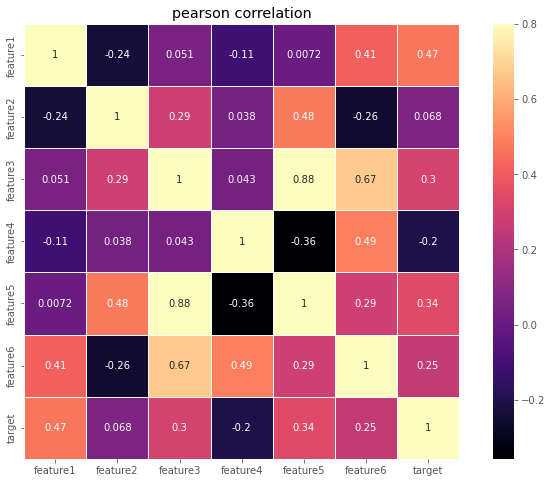

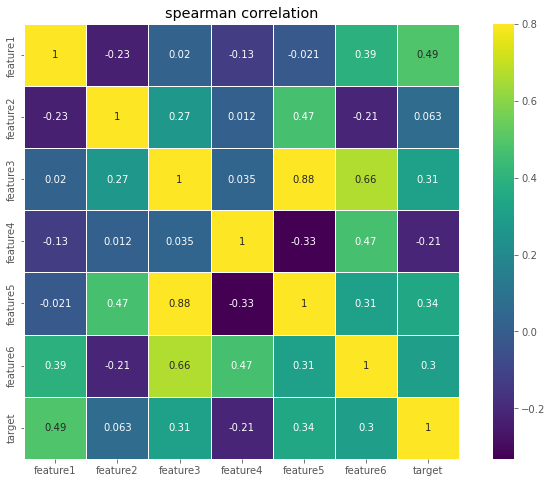

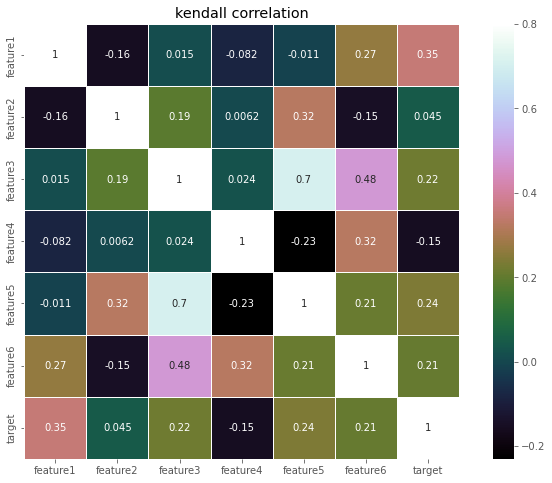

In [19]:
correlation_2(train)

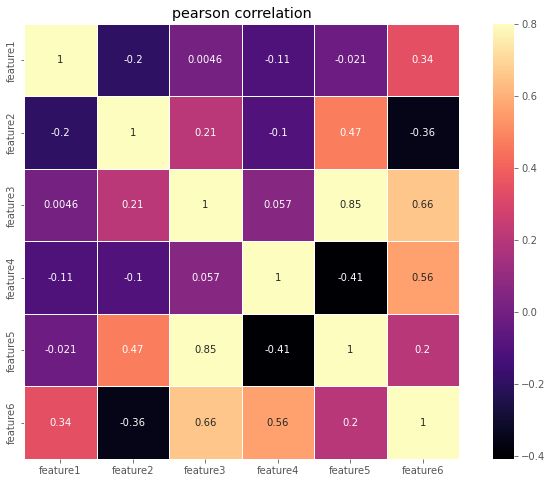

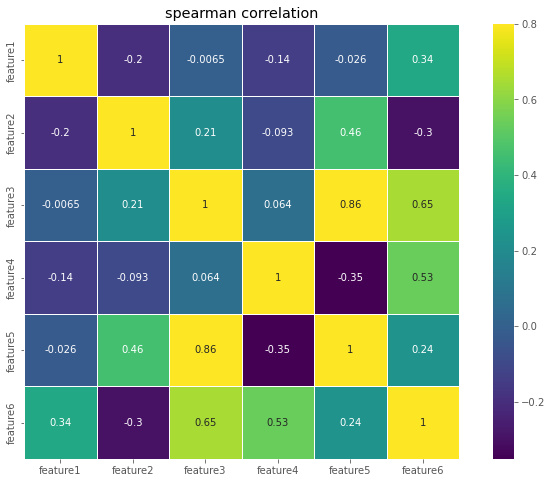

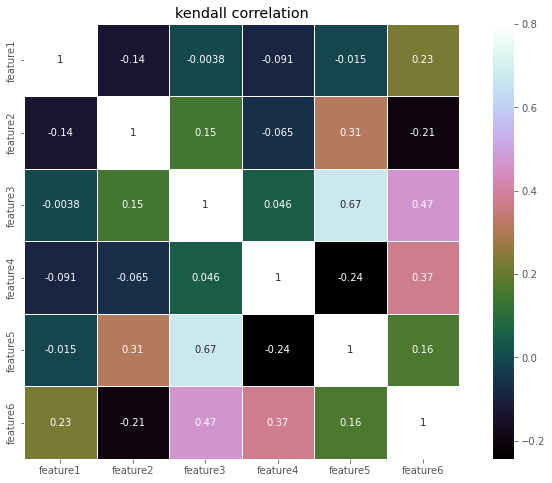

In [20]:
correlation_2(test)

Surprisingly enough, notice how the order of the higher to smaller correlation is as follows: Pearson, Spearman, Kendall. This means that indeed, there is a more linear relation than non-linear. 

In [21]:
def boxplots(dataframe=X, y=y):
    for feature in dataframe.columns[:]:
        plt.figure(figsize=(9, 6))
        sns.boxplot(x=y,y=feature, data=dataframe)
        plt.grid(True)
        plt.show()

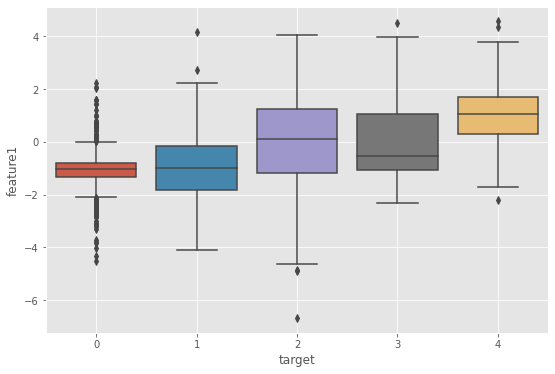

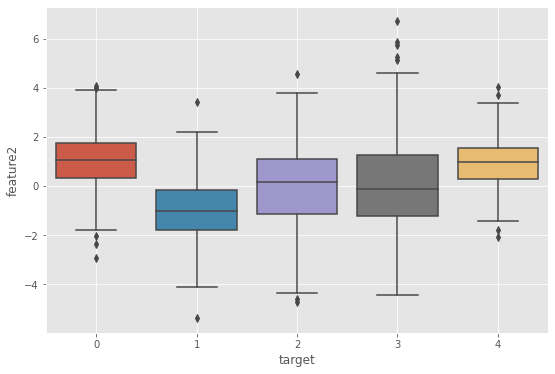

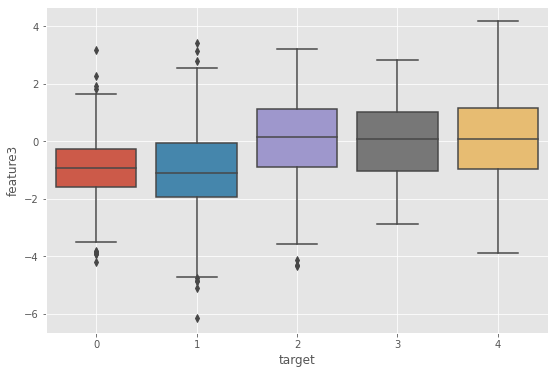

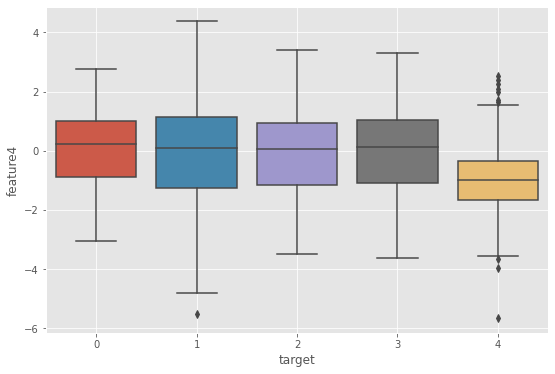

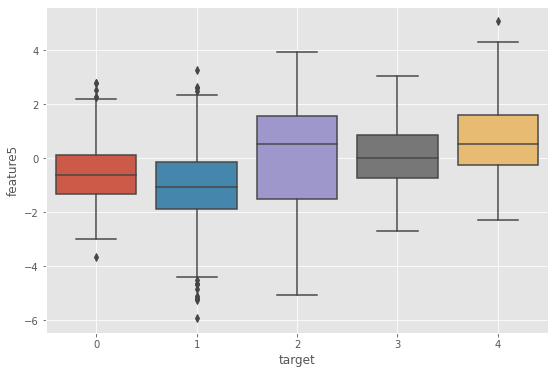

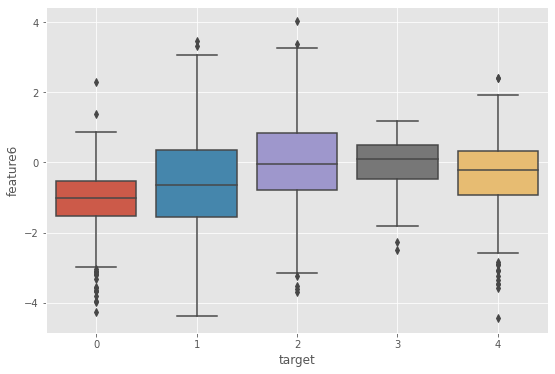

In [22]:
boxplots()

It also seems that there is similarity and symmetry between the both sides. A priori, we can say that this dataset is clean and has a well-distributed data. 

In [23]:
def distplot(dataframe=X):
    for feature in dataframe.columns[:]:
        plt.figure(figsize=(9, 6))
        sns.distplot(X[feature], color= np.random.choice(colors))
        plt.show()

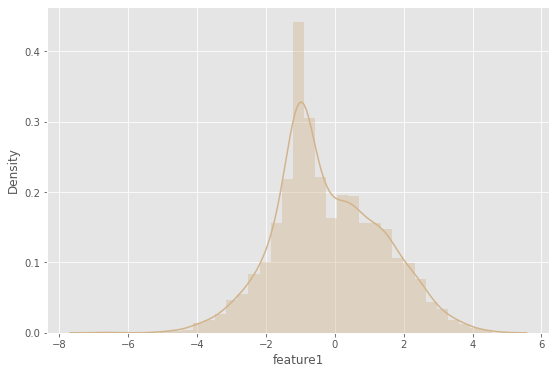

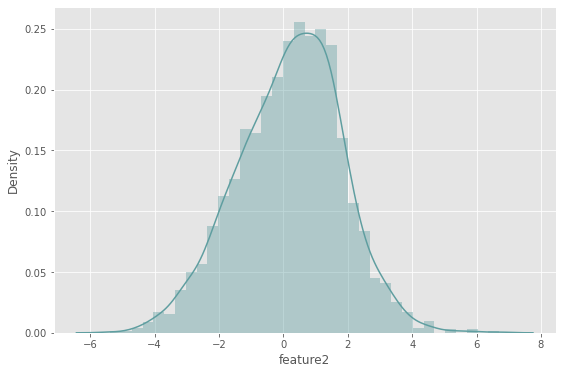

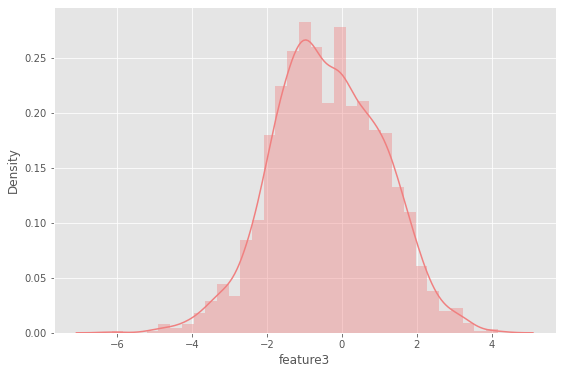

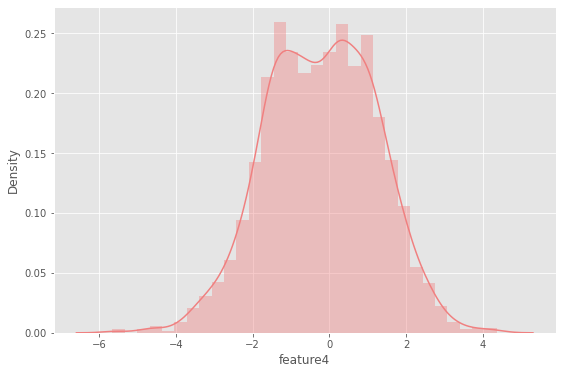

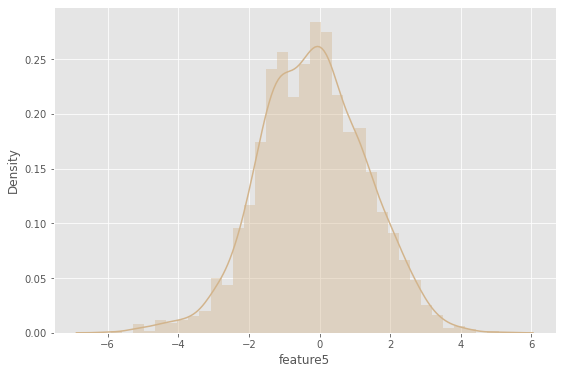

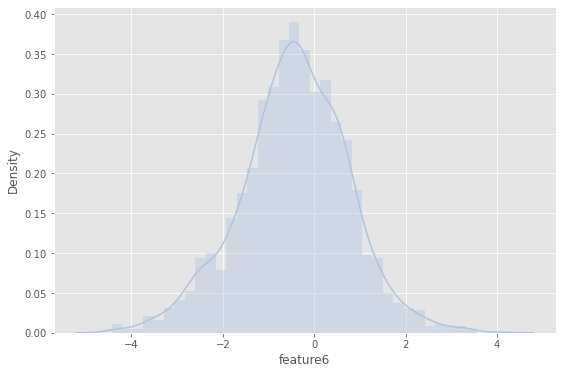

In [24]:
distplot()

<AxesSubplot:xlabel='target', ylabel='count'>

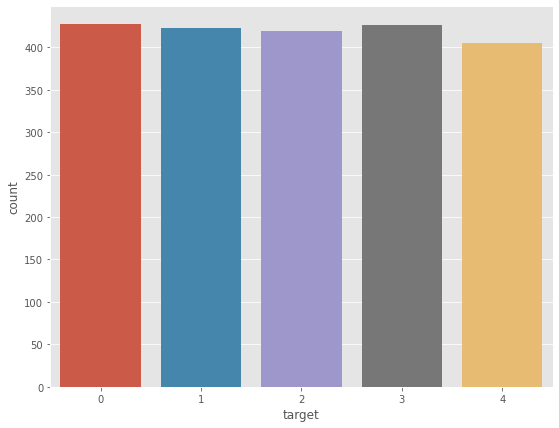

In [25]:
sns.countplot(train["target"])

<!-- def moments(x, y):
    print(f"Skewness of {y}: %f" % x[y].skew())
    print(f"Kurtosis of {y}: %f" % x[y].kurt())
    print(f"Median of {y}: %f" % x[y].median()) -->

In [26]:
def moments(dataframe):
    for i in range(1, 7):
        feature = "feature" + str(i)
        print(f"Skewness of {feature}: %f" % dataframe[feature].skew())
        print(f"Kurtosis of {feature}: %f" % dataframe[feature].kurt())
        print(f"Median of {feature}: %f" % dataframe[feature].median())
        print()

In [27]:
moments(train)

Skewness of feature1: 0.193572
Kurtosis of feature1: -0.041193
Median of feature1: -0.443868

Skewness of feature2: -0.143889
Kurtosis of feature2: 0.102713
Median of feature2: 0.320507

Skewness of feature3: -0.029870
Kurtosis of feature3: -0.067041
Median of feature3: -0.439745

Skewness of feature4: -0.099428
Kurtosis of feature4: -0.125247
Median of feature4: -0.176504

Skewness of feature5: -0.072978
Kurtosis of feature5: 0.185408
Median of feature5: -0.195751

Skewness of feature6: -0.122680
Kurtosis of feature6: 0.460712
Median of feature6: -0.406754



Non of the moments we measured, is above 1, the distributions are centered (We can assert this by taking a look at the distplots). The quantity of each target seems to be also equally distributed. 

<!-- for i in range(1, 7):
    feature = "feature" + str(i)
    moments(train, feature)
    print() -->

<!-- # train.feature1.apply(moments)
# train["feature1"].apply(lambda x: x.skew()) -->

<!-- # train.apply(moments(train, "feature1")) -->

In [28]:
def scatterplot(dataframe):
    for i in range(1, 7):
        feature_i = "feature" + str(i)
        for j in range(1, 7):
            feature_j = "feature" + str(j)
            plt.figure(figsize=(9, 4))
            plt.title("Scatterplot for {} & {}".format(feature_i, feature_j))
            plt.scatter(dataframe[feature_i], dataframe[feature_j], color=np.random.choice(colors))
            plt.xlabel(feature_i)
            plt.ylabel(feature_j)

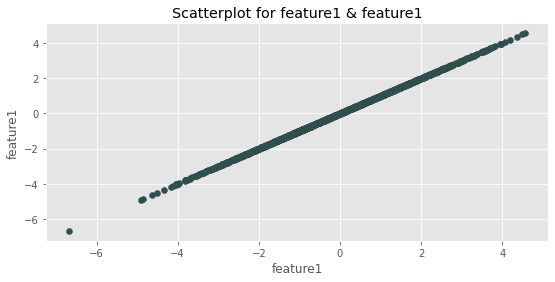

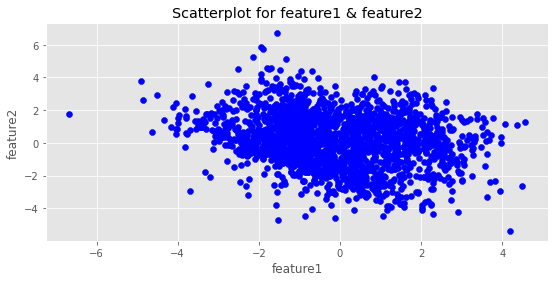

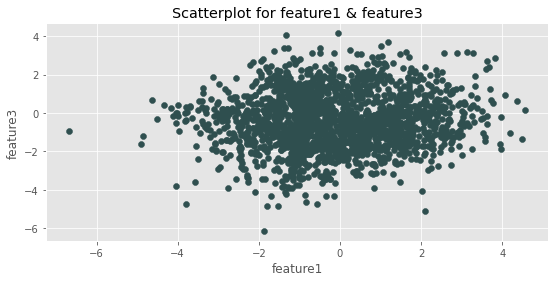

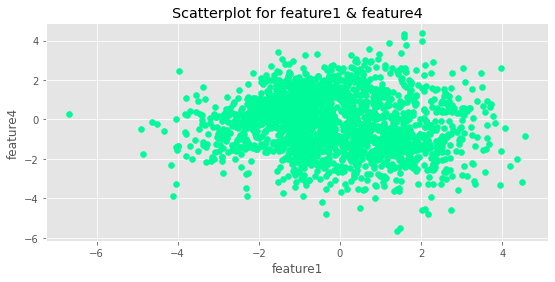

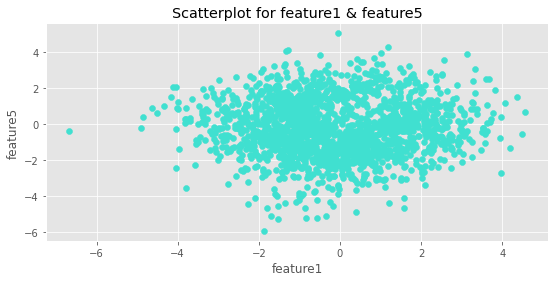

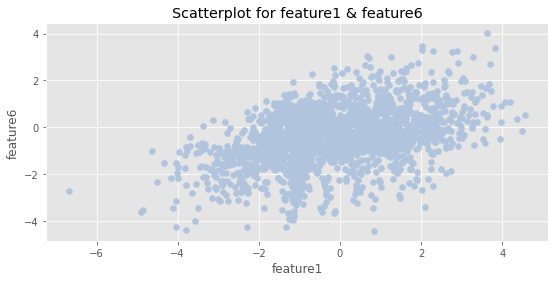

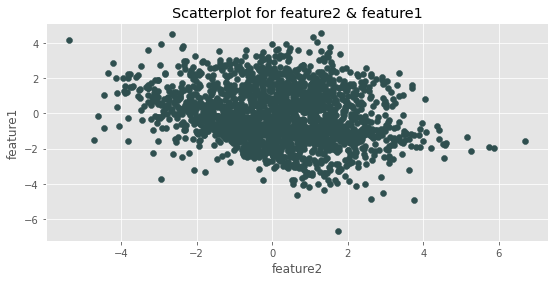

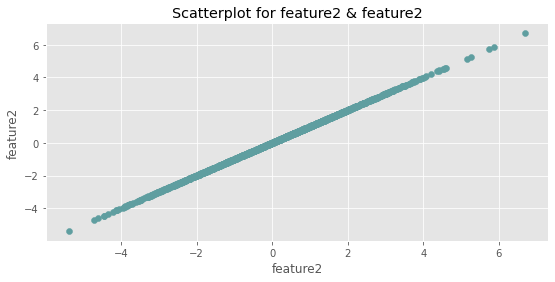

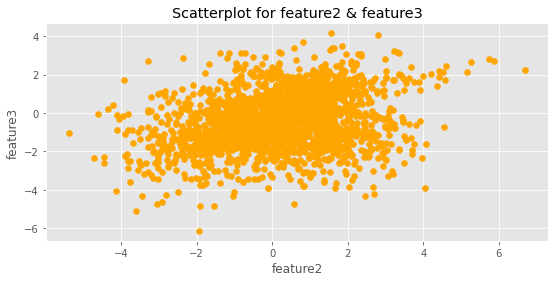

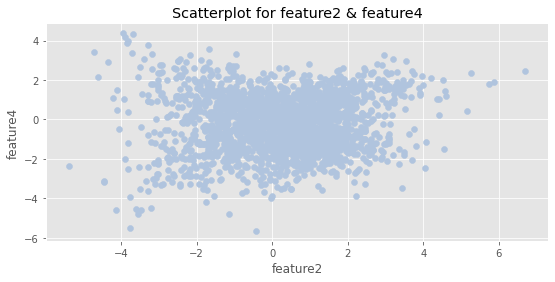

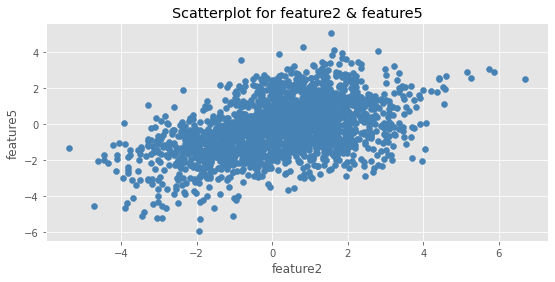

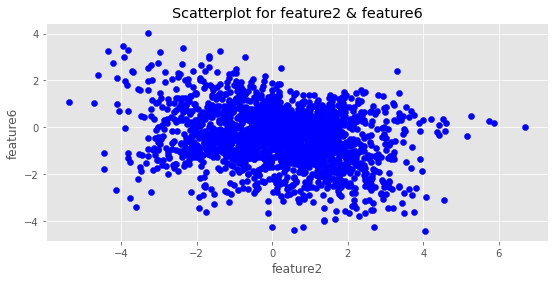

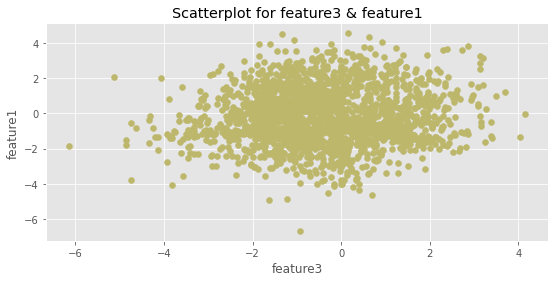

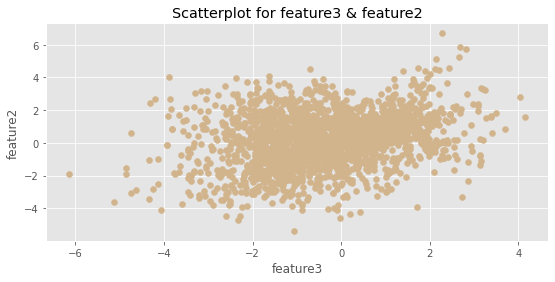

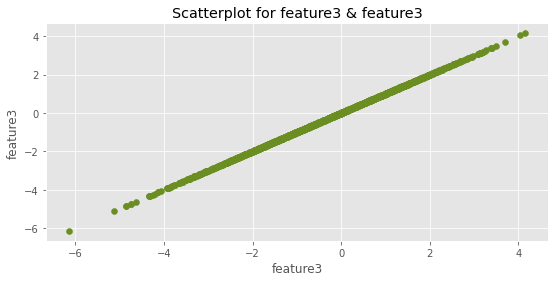

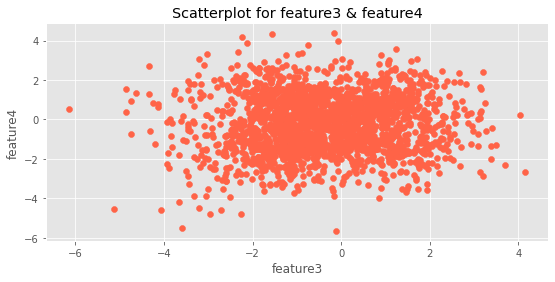

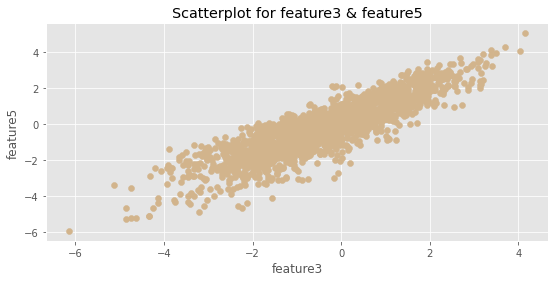

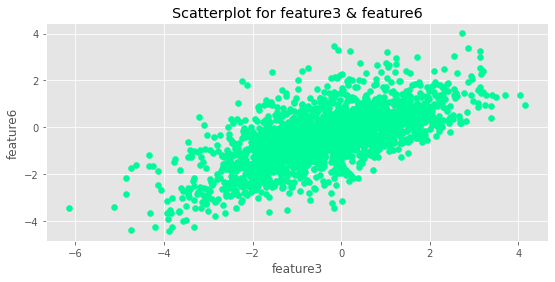

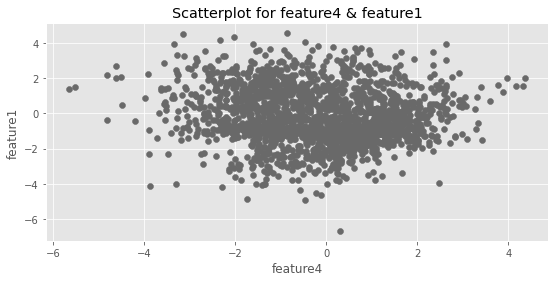

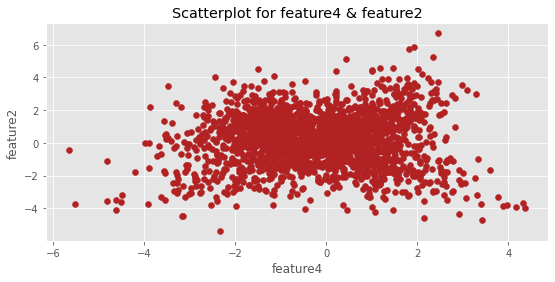

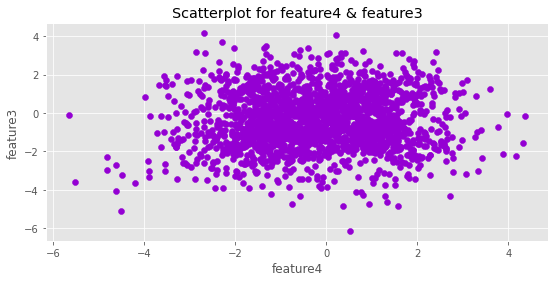

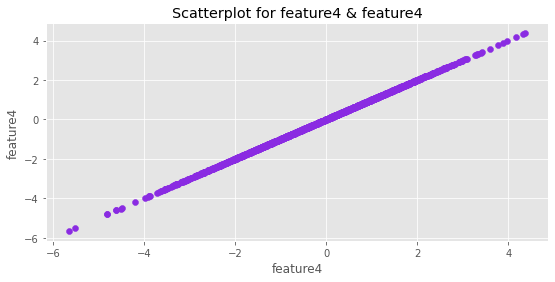

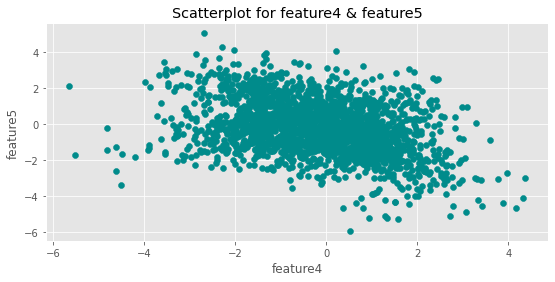

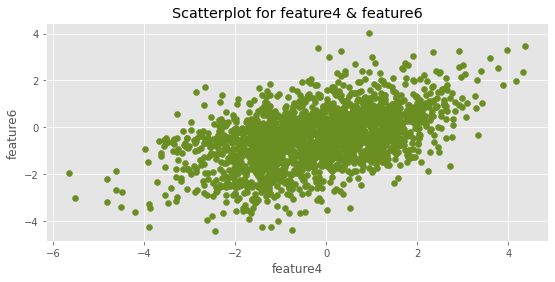

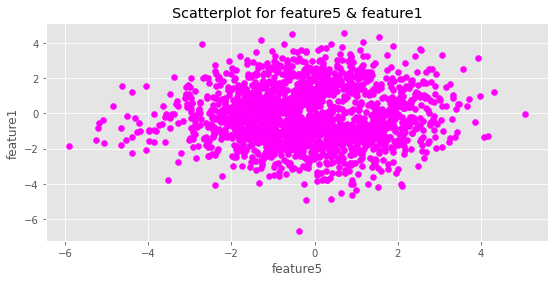

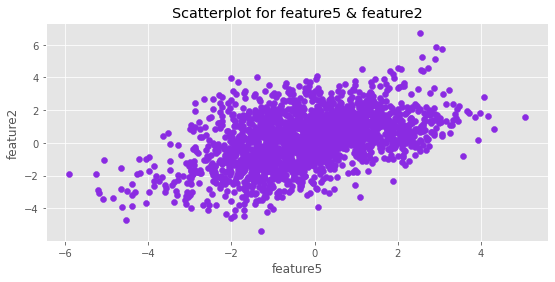

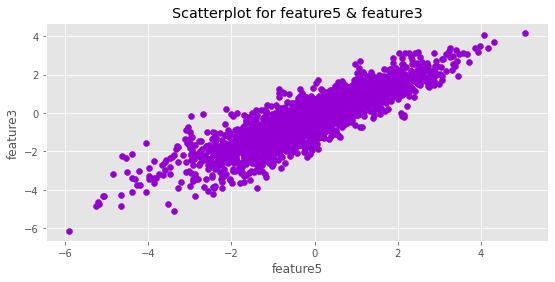

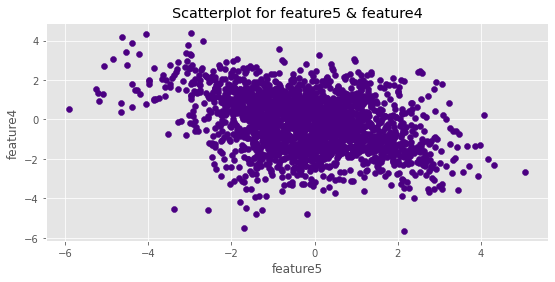

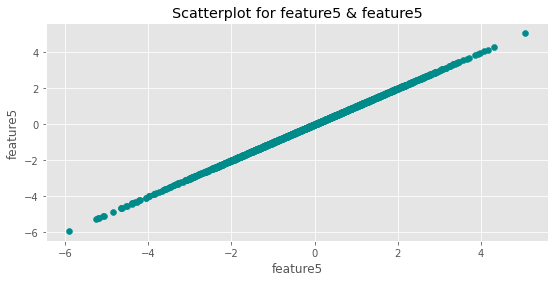

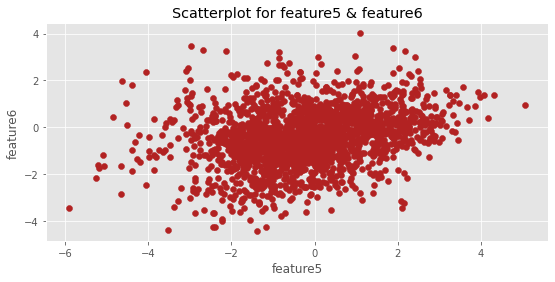

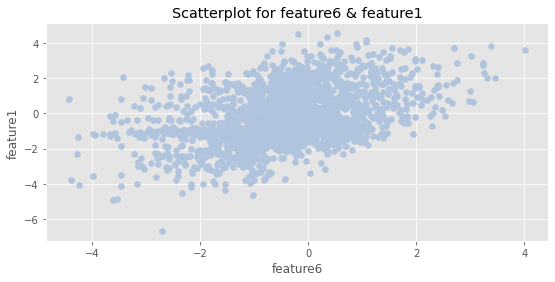

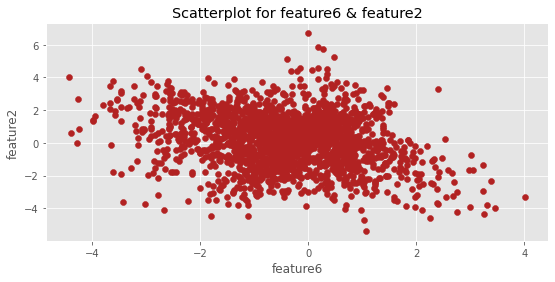

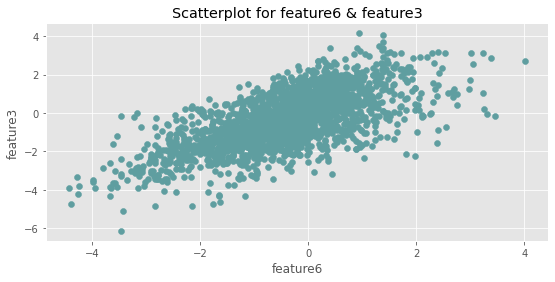

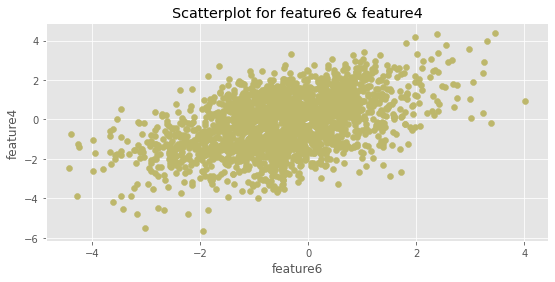

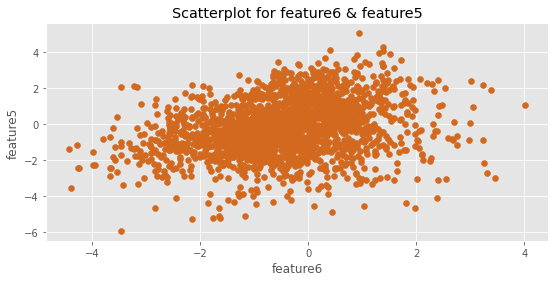

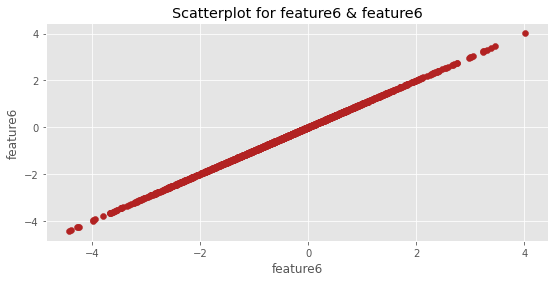

In [29]:
scatterplot(train)

We don't see any pattern in the bivariate analysis, since there isn't a strong correlation. In fact, the data is well dispersed.

##### KDE and Simpson's paradox 

<!-- def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(train[train["target"] == 0][feature].dropna(), color= "navy", label= "target: 0")
    ax1 = sns.kdeplot(train[train["target"] == 1][feature].dropna(), color= "orange", label= "target: 1")
    ax2 = sns.kdeplot(train[train["target"] == 2][feature].dropna(), color= "red", label= "target: 2")
    ax3 = sns.kdeplot(train[train["target"] == 3][feature].dropna(), color= "green", label= "target: 3")
    ax4 = sns.kdeplot(train[train["target"] == 4][feature].dropna(), color= "cadetblue", label= "target: 4")    
    plt.legend(loc="upper left") -->

In [30]:
def kdeplot(dataframe):
    for i in range(1, 7):
        feature = "feature" + str(i)
        plt.figure(figsize=(9, 4))
        plt.title("KDE for {}".format(feature))
        ax0 = sns.kdeplot(dataframe[dataframe["target"] == 0][feature].dropna(), color= "navy", label= "target: 0")
        ax1 = sns.kdeplot(dataframe[dataframe["target"] == 1][feature].dropna(), color= "orange", label= "target: 1")
        ax2 = sns.kdeplot(dataframe[dataframe["target"] == 2][feature].dropna(), color= "red", label= "target: 2")
        ax3 = sns.kdeplot(dataframe[dataframe["target"] == 3][feature].dropna(), color= "green", label= "target: 3")
        ax4 = sns.kdeplot(dataframe[dataframe["target"] == 4][feature].dropna(), color= "cadetblue", label= "target: 4")    
        ax5 = sns.kdeplot(dataframe[dataframe["target"] <= 4][feature], color= "black", label= "Density combined")
        plt.legend(loc="upper left")

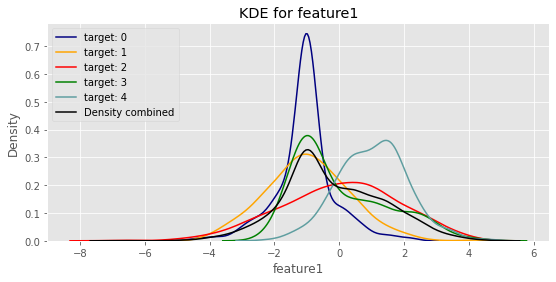

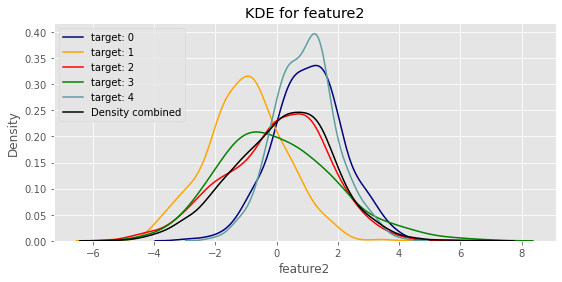

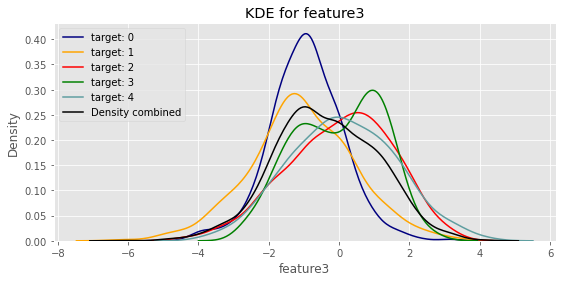

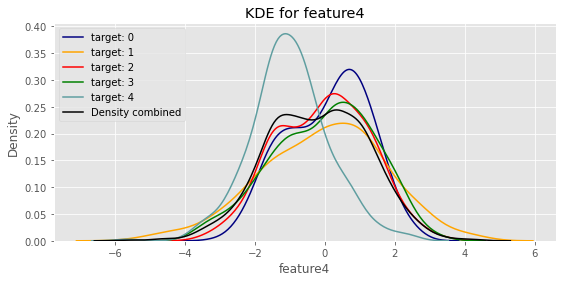

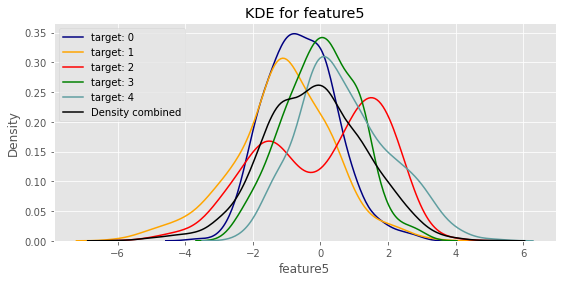

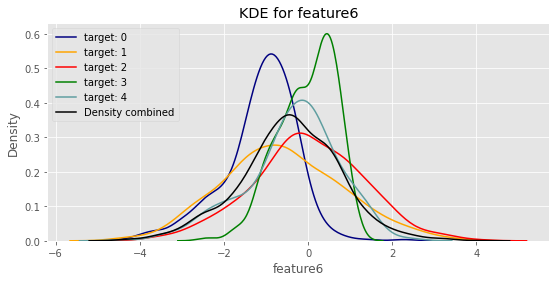

In [31]:
kdeplot(train)

Kernel Density Estimation is the function that groups all the probability under it's shape. It's an easy straight-forward way to check for the shape of the distribution. On the other hand, we might also look up for a phenomenon called the Simpson's paradox (Which is not present). The Simpson's paradox is the phenomenon where data behaves differently once we divide it into other subsets, changing this way, the tottality of the the patterns. As we can see, there is no sign of Simpson's paradox since we've combined our KDEs into the last density functions and see almost no difference respect the rest of KDEs from the other targets. 

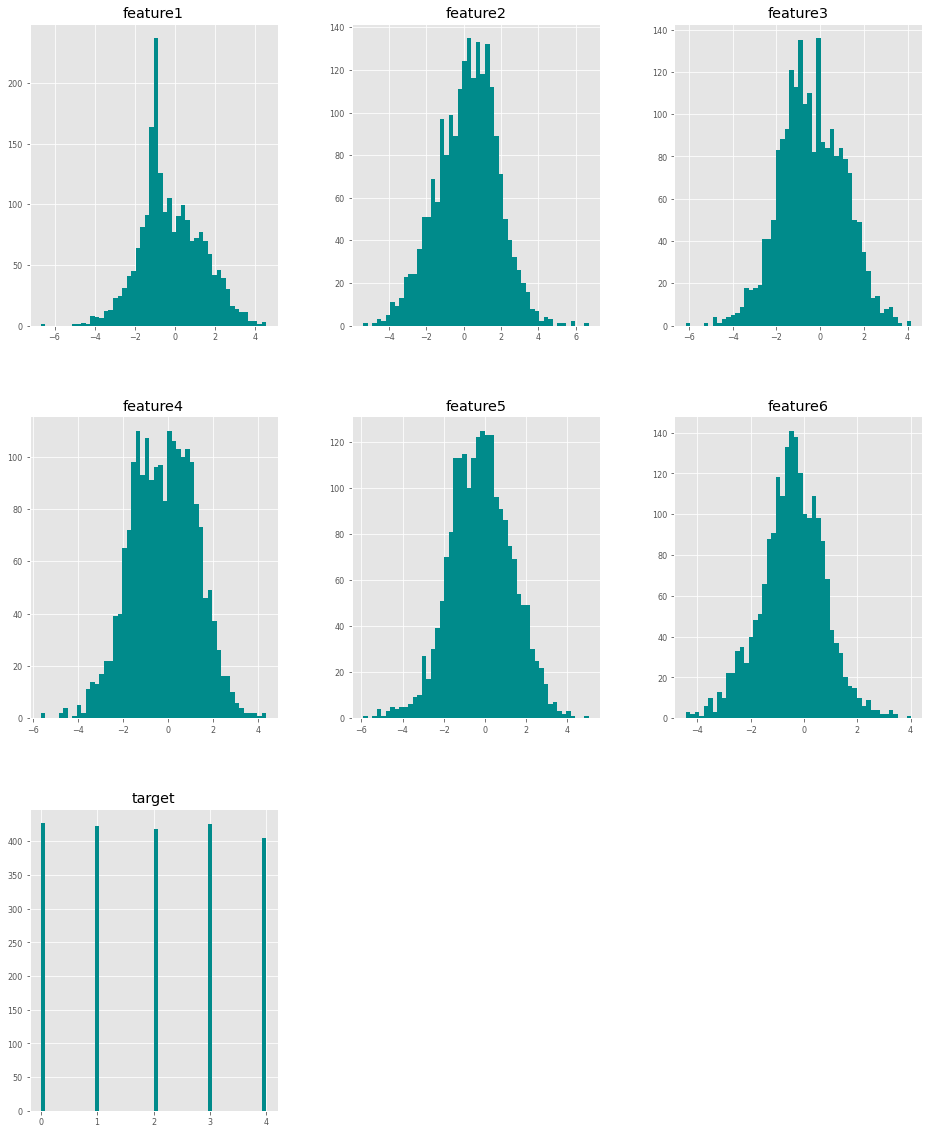

In [32]:
train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color="darkcyan"); 

In [33]:
def reg_plot(dataframe=train, columns=columns):
    c = 0
    for i in range(1, 7):
        feature_i = columns[i-1]
        for j in range(1, 7):       
            feature_j = columns[j-1]
            if i != j:
                sns.regplot(x=feature_i, y=feature_j, data=dataframe, marker=markers[c], color=colors[c])
                plt.show()
                c += 1
                if c >= len(markers) or c >= len(colors):
                    c = 0

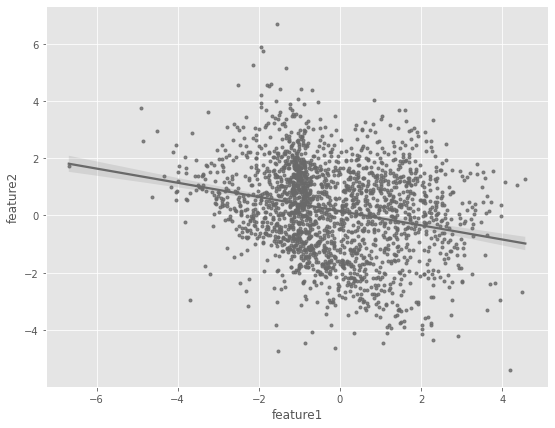

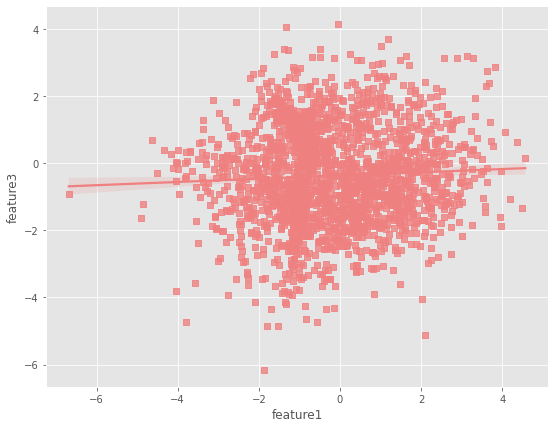

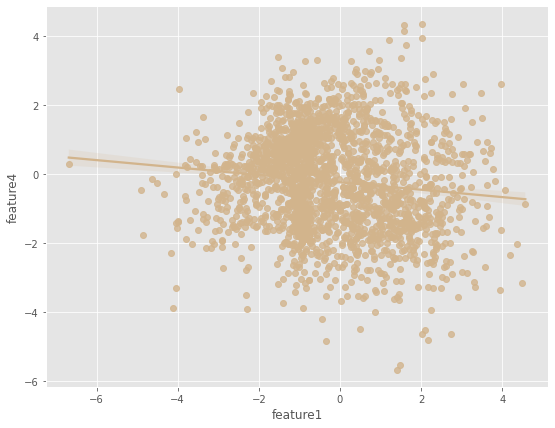

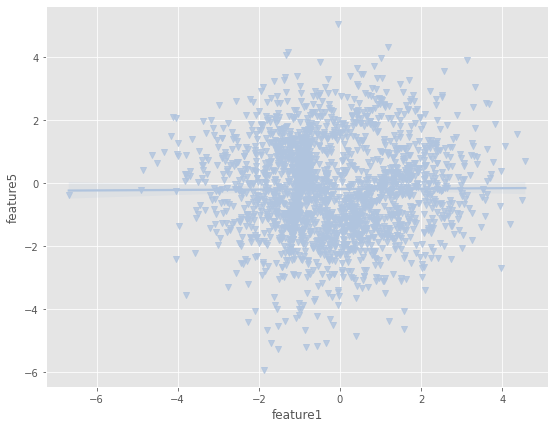

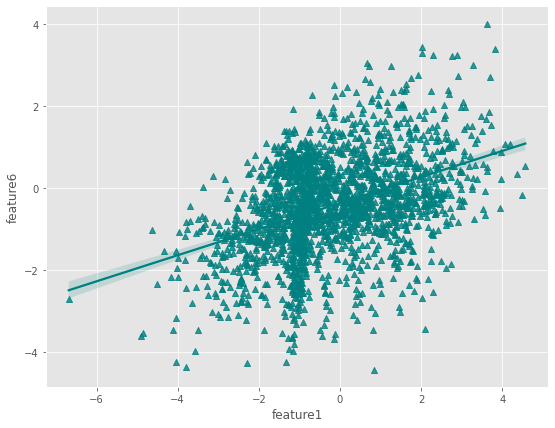

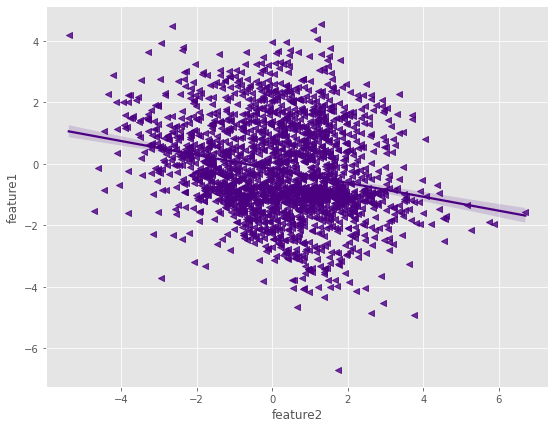

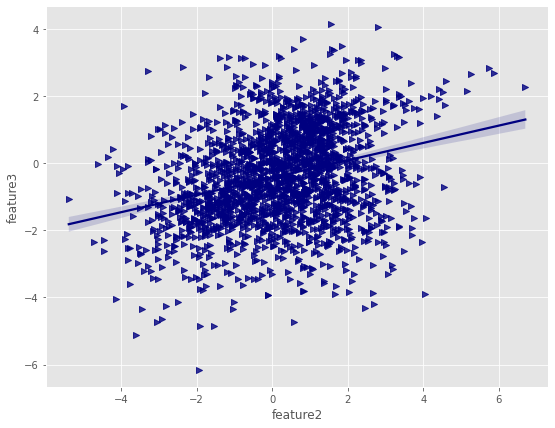

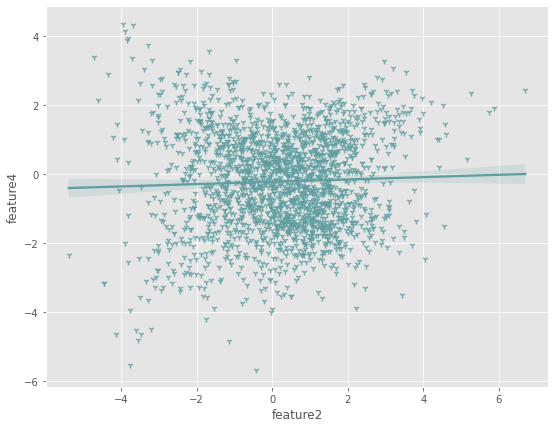

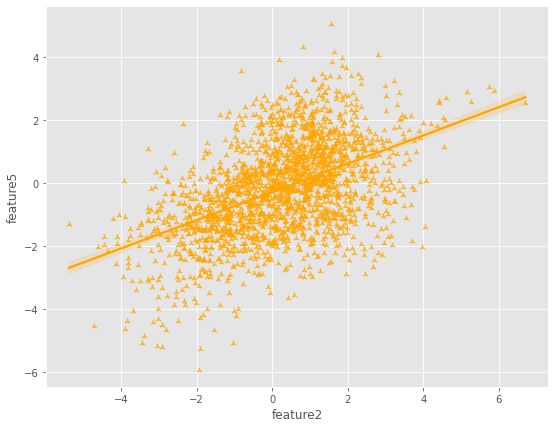

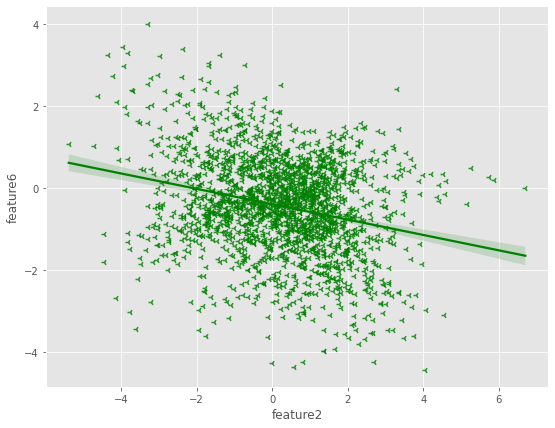

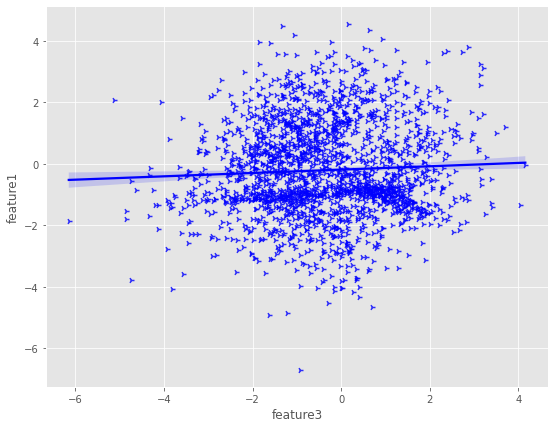

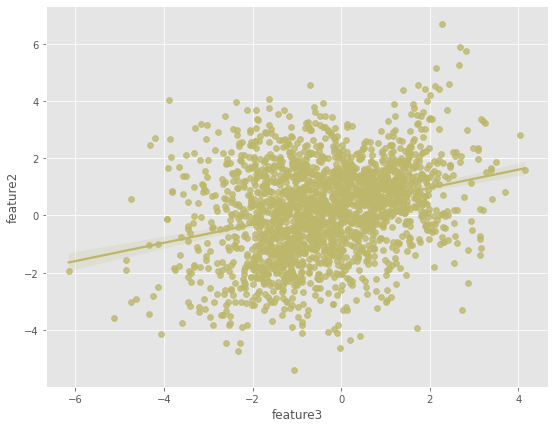

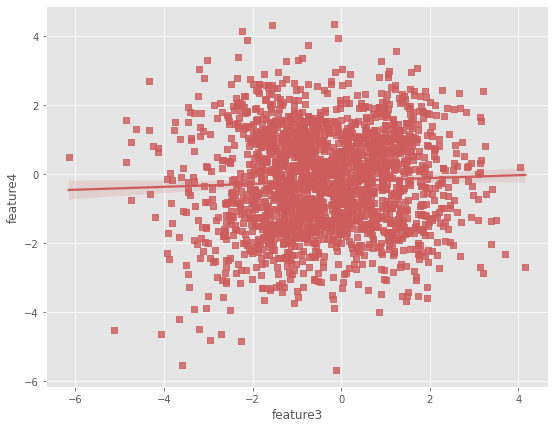

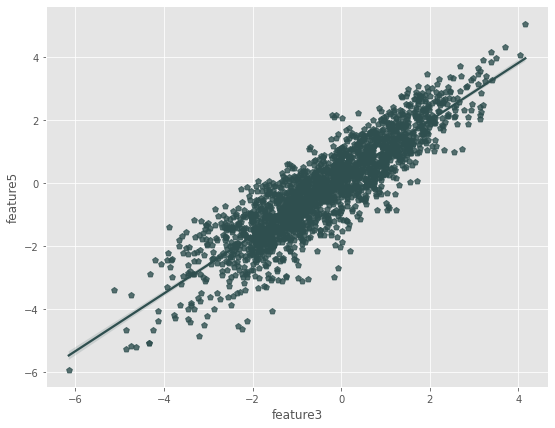

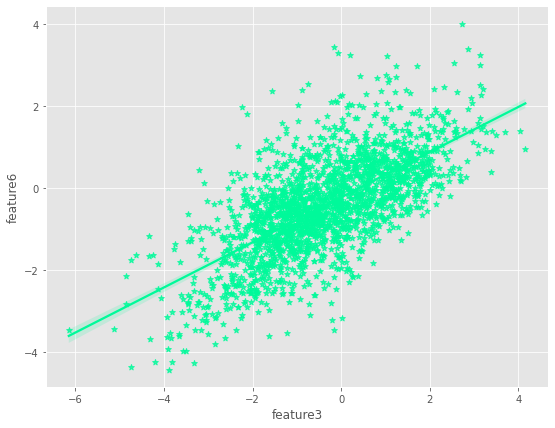

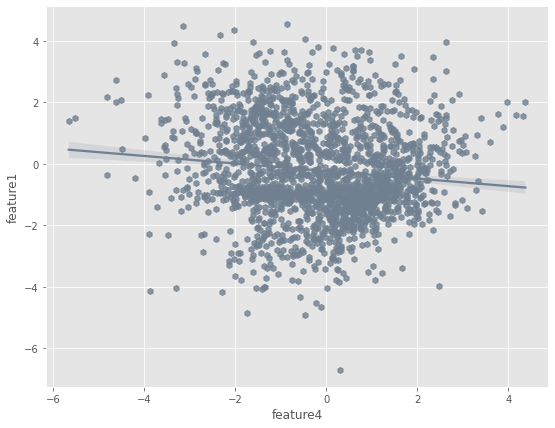

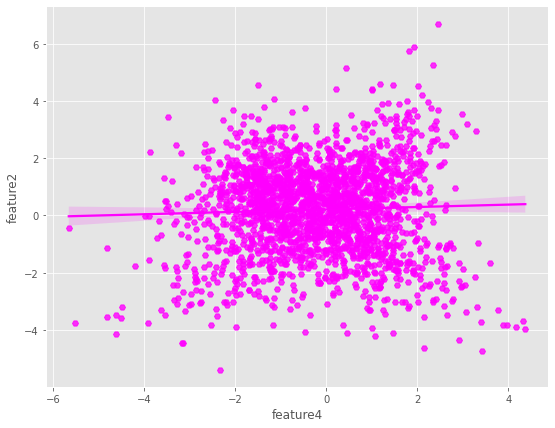

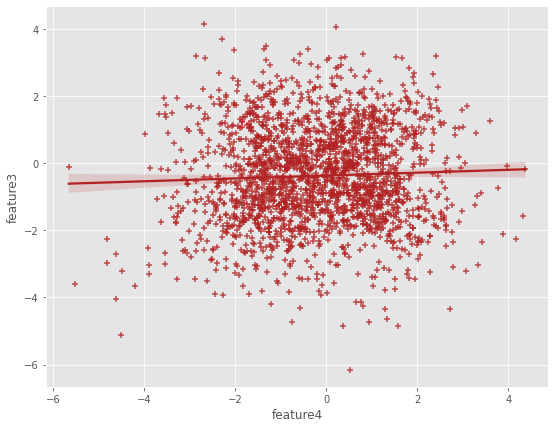

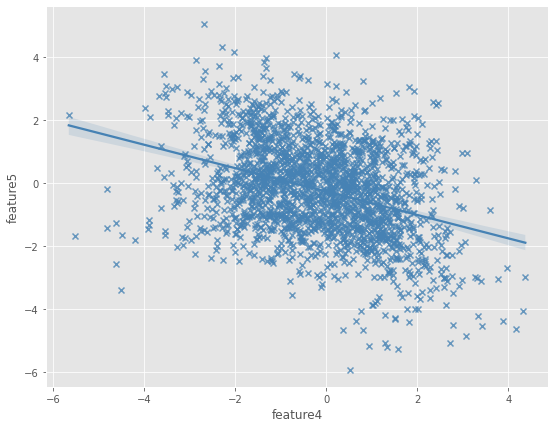

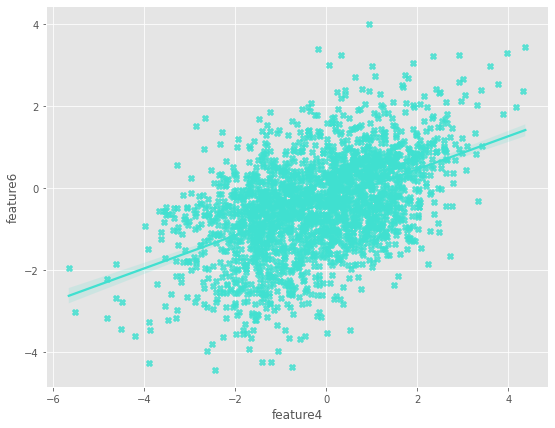

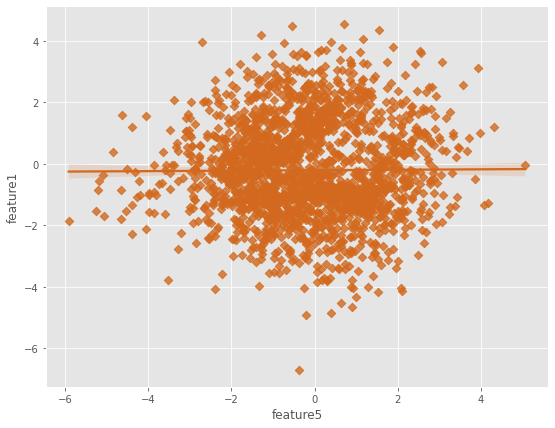

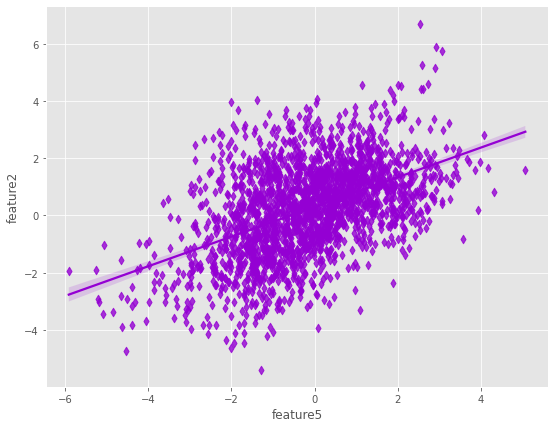

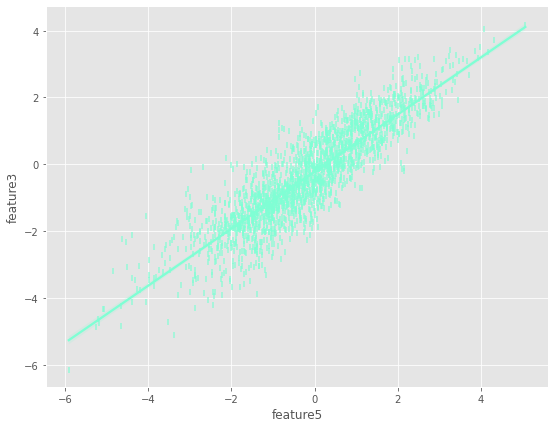

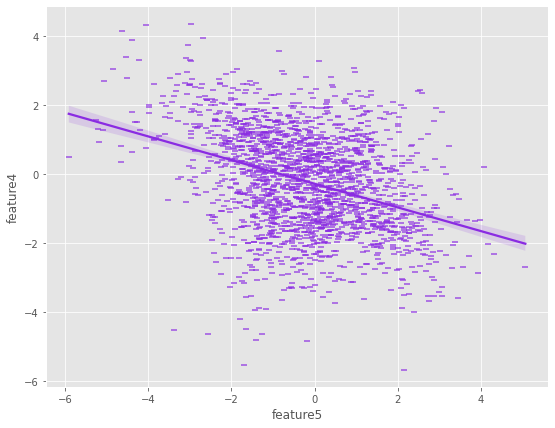

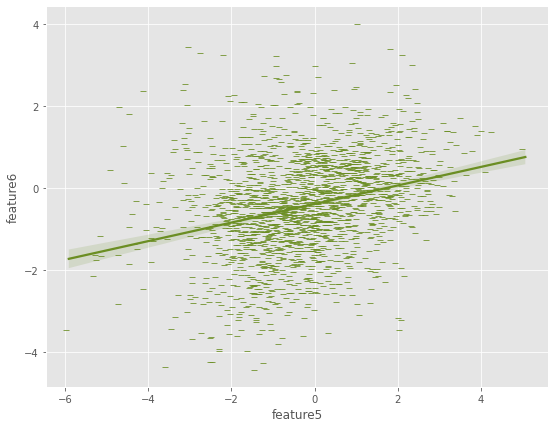

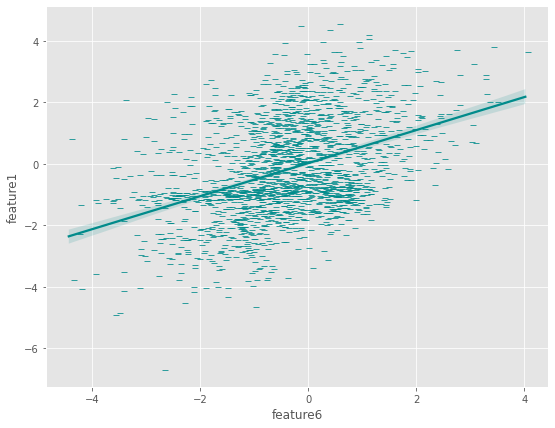

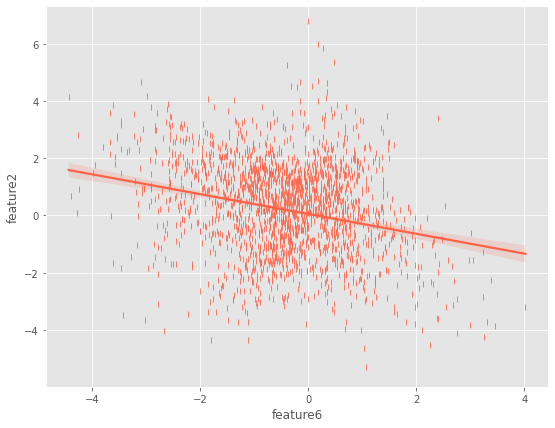

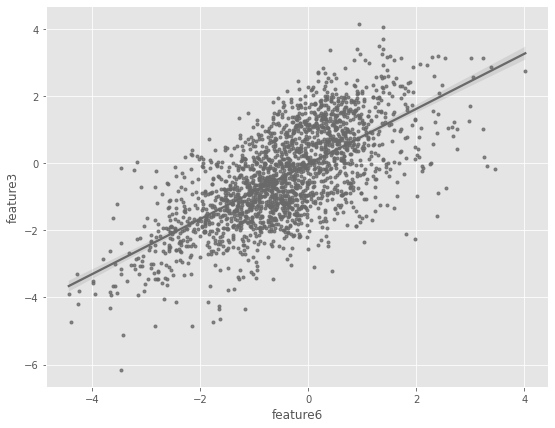

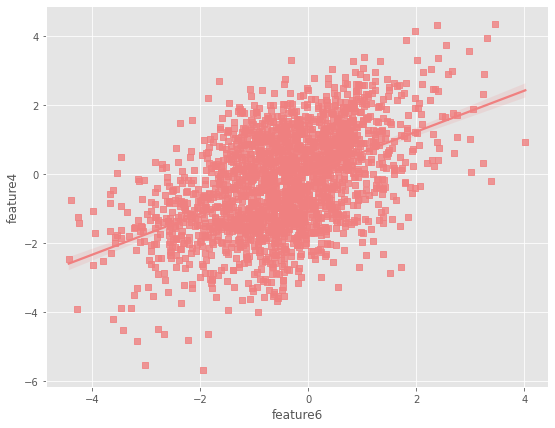

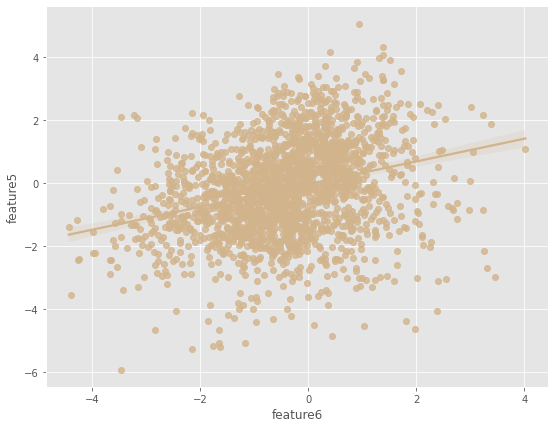

In [34]:
reg_plot(train)

It appears to be that the strongest relation amongst all features occurs between feature3 and feature5, as well as featurue3 and feature6. 

##### Normality, Variance and Independence tests for ANOVA

One of the prerequisites to execute One-Way ANOVA tests is to have normality in it's distribution so we will use qq-plots and Shapiro-Wilk tests.

In [35]:
def qqplot(dataframe=X):
    for i in range(1, 7):
        feature = "feature" + str(i)
        for z in ["q", "s"]:
            c = ""
            if z == "q":
                c = "line fit through quantiles"
            else:
                c = "line fit to standardized data"
            sm.qqplot(dataframe[feature], line = z)
            plt.title("qqplot with " + str(c))
            plt.show()

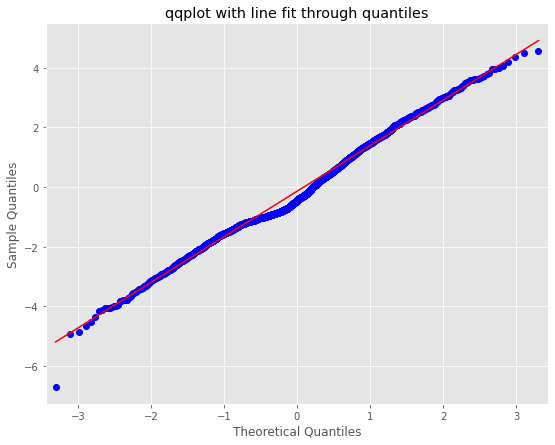

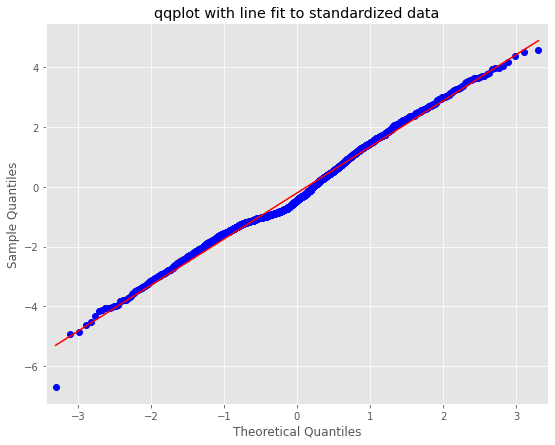

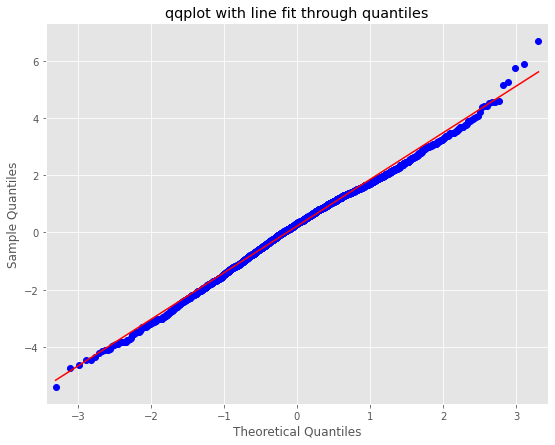

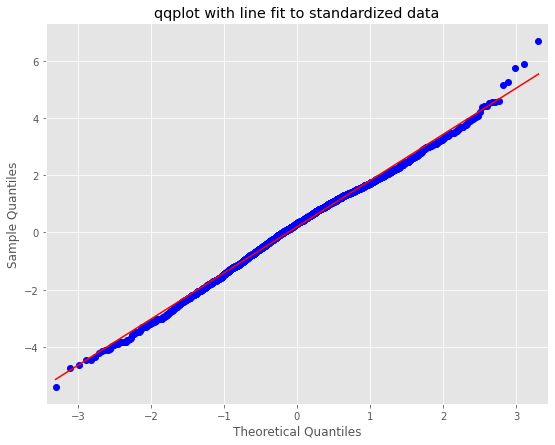

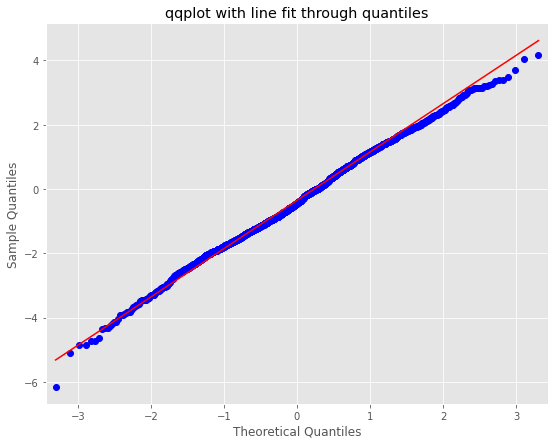

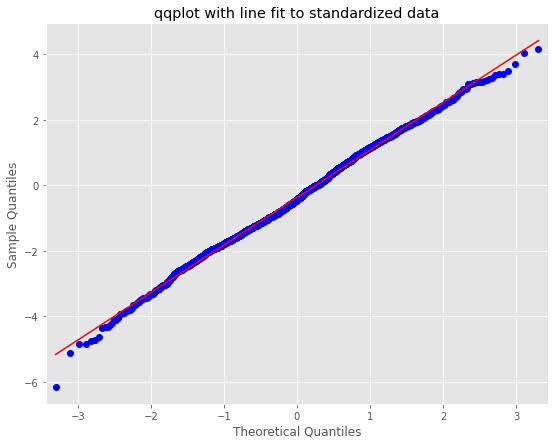

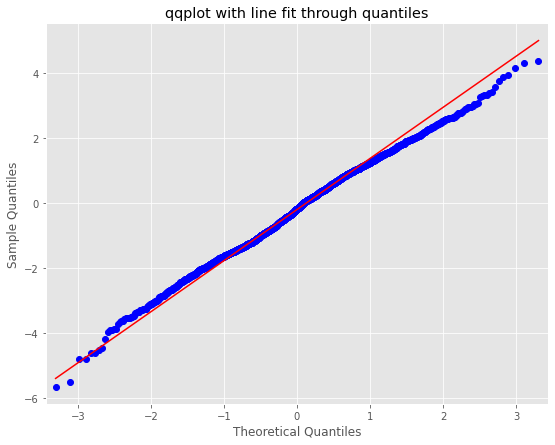

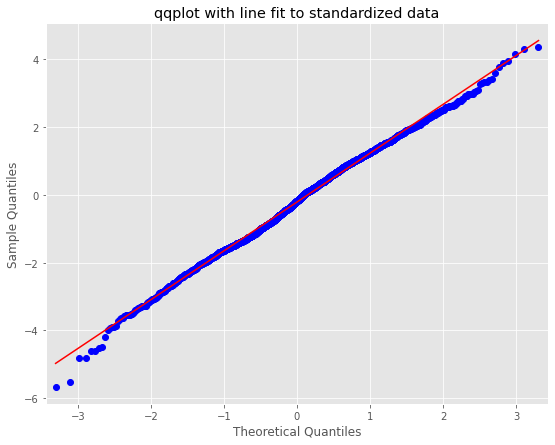

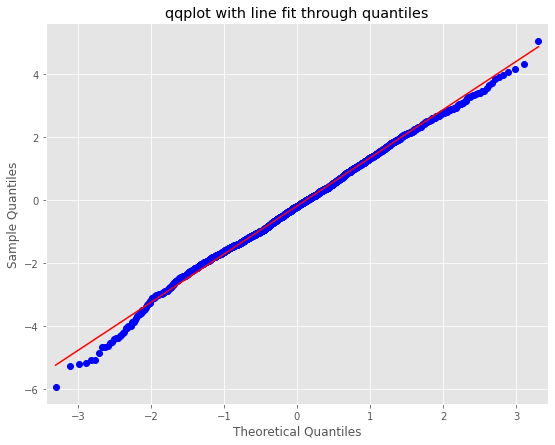

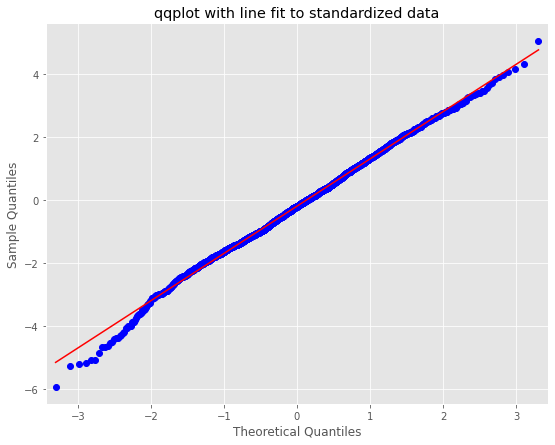

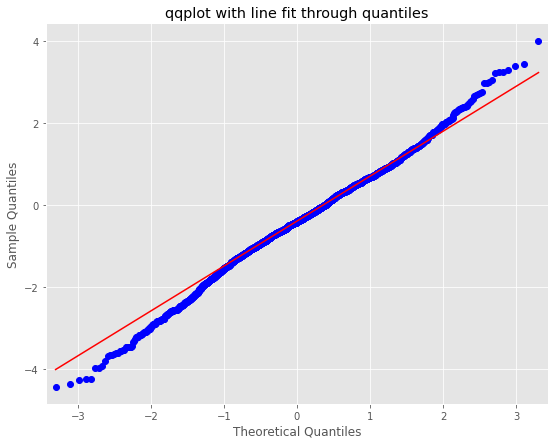

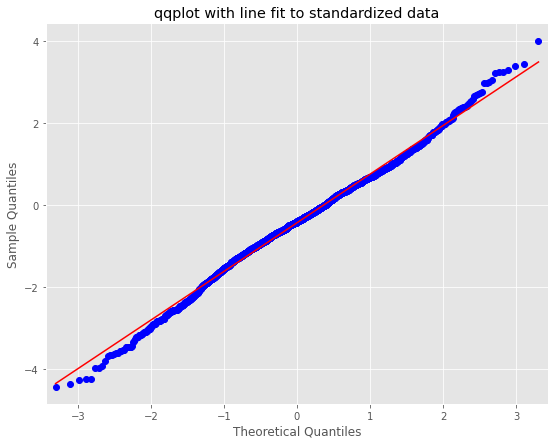

In [36]:
qqplot()

The null-hypothesis of this test is that the population is normally distributed

In [37]:
def sw_test(dataframe=X):
    nd = []
    for i in range(1, 7):
        feature = "feature" + str(i)
        sap_result = stats.shapiro(dataframe[feature]).pvalue
        if sap_result < 0.05:
            print(f"{feature}-> We reject the null hypothesis, the empyrical distribution for the variable {feature} doesn't come from a normal distribution.\n")
        else:
            print(f"{feature}-> We fail to reject the null hypothesis. Therefore, the empyrical distribution for the variable {feature} follows a normal distribution.\n")
            nd.append(feature)
    return nd

In [38]:
nd = sw_test()

feature1-> We reject the null hypothesis, the empyrical distribution for the variable feature1 doesn't come from a normal distribution.

feature2-> We reject the null hypothesis, the empyrical distribution for the variable feature2 doesn't come from a normal distribution.

feature3-> We reject the null hypothesis, the empyrical distribution for the variable feature3 doesn't come from a normal distribution.

feature4-> We reject the null hypothesis, the empyrical distribution for the variable feature4 doesn't come from a normal distribution.

feature5-> We reject the null hypothesis, the empyrical distribution for the variable feature5 doesn't come from a normal distribution.

feature6-> We reject the null hypothesis, the empyrical distribution for the variable feature6 doesn't come from a normal distribution.



In [39]:
nd

[]

Although visually we see that the qq-plots indicate that the distributions are normal, it appears to be that our shapiro-wilk test contradicts that statement. Nevertheless, it is not absolutely required to have a normally distributed data to perform Anova. As well, you could perform Anova with disparity in variance distributions. 

To assess for the variance, we can do two things. One of them is to visually check the boxplots and see if they are symmetric and more or less equally distributed, which we already did. On the other hand, we can implement the Bartlett’s Test to check for variance homogeneity. Therefore, we shall proceed.

In [40]:
def bartlett_test(dataframe=X):
    pairs = []
    for i in range(1, 7):
        feature_i = "feature" + str(i)
        for j in range(1, 7):
            feature_j = "feature" + str(j)
            if feature_i != feature_j:
                statistic, pvalue = stats.bartlett(X[feature_i], X[feature_j])
                if pvalue < 0.05:
                    print(f"{feature_i} & {feature_j}-> We reject the null hypothesis, the empyrical distributions for the variables {feature_i} and {feature_j} have diferent variance.\n")
                else:
                    print(f"{feature_i} & {feature_j}-> We fail to reject the null hypothesis. Therefore, the empyrical distributions for the variables {feature_i} and {feature_j} have homogenous variance.\n")
                    pairs.append((feature_i, feature_j))
    return pairs        

In [41]:
var_pairs = bartlett_test()

feature1 & feature2-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature2 have diferent variance.

feature1 & feature3-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature3 have diferent variance.

feature1 & feature4-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature4 have diferent variance.

feature1 & feature5-> We fail to reject the null hypothesis. Therefore, the empyrical distributions for the variables feature1 and feature5 have homogenous variance.

feature1 & feature6-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature6 have diferent variance.

feature2 & feature1-> We reject the null hypothesis, the empyrical distributions for the variables feature2 and feature1 have diferent variance.

feature2 & feature3-> We reject the null hypothesis, the empyrical distributions for the variables feat

In [42]:
var_pairs

[('feature1', 'feature5'),
 ('feature3', 'feature4'),
 ('feature3', 'feature5'),
 ('feature4', 'feature3'),
 ('feature4', 'feature5'),
 ('feature5', 'feature1'),
 ('feature5', 'feature3'),
 ('feature5', 'feature4')]

As we can appreaciate from our results, there are some pairs that are indeed equal in how the variance is distributed.

Our third and last assumption to conduct the Anova is to confidently rely on the idea that the values are independent. 

##### Anova

<!-- temp_df = train[["target", "feature1"]].groupby(["target"])
stats.f_oneway(temp_df.get_group(0)["feature1"],temp_df.get_group(1)["feature1"]) -->

<!-- def one_way_anova(dataframe):
    for i in range(1, 7):
        feature = "feature" + str(i)
        temp_df = dataframe[["target", feature]].groupby(["target"])
        f_statistic, p_value = stats.f_oneway(temp_df.get_group(0)[feature],temp_df.get_group(1)[feature])
        print(f"For {feature} -> The F-statistic and P_value have a value of {round(f_statistic, 3)} and {round(p_value, 3)} respectively for the '{feature}' feature.")
        if p_value < 0.05:
            print(f"Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!")
        print() -->

In [43]:
def one_way_anova(dataframe=train):
    results = []
    for i in range(1, 7):
        feature = "feature" + str(i)
        temp_df = dataframe[["target", feature]].groupby(["target"])
        print(f"For {feature} with value:\n")
        for j in range(5):
            for k in range(5):
                if j != k:
                    f_statistic, p_value = stats.f_oneway(temp_df.get_group(j)[feature],temp_df.get_group(k)[feature])
                    print(f"For targets with class {j} and {k} -> The F-statistic and P_value have values of {round(f_statistic, 3)} and {round(p_value, 3)} respectively.")
                    if p_value < 0.05:
                        print(f"Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!")
                        results.append((round(f_statistic, 2), j, k))
                    print()
            print("------\n")
        print("------\n")
    return results

In [44]:
anova_pairs = one_way_anova(train)

For feature1 with value:

For targets with class 0 and 1 -> The F-statistic and P_value have values of 1.003 and 0.317 respectively.

For targets with class 0 and 2 -> The F-statistic and P_value have values of 116.706 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 0 and 3 -> The F-statistic and P_value have values of 163.647 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 0 and 4 -> The F-statistic and P_value have values of 913.875 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

------

For targets with class 1 and 0 -> The F-statistic and P_value have values of 1.003 and 0.317 respectively.

For targets with clas

For targets with class 1 and 0 -> The F-statistic and P_value have values of 1.733 and 0.188 respectively.

For targets with class 1 and 2 -> The F-statistic and P_value have values of 112.58 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 1 and 3 -> The F-statistic and P_value have values of 124.99 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 1 and 4 -> The F-statistic and P_value have values of 122.846 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

------

For targets with class 2 and 0 -> The F-statistic and P_value have values of 121.431 and 0.0 respectively.
Notice that the P-value is under our threshold of 


------

For targets with class 1 and 0 -> The F-statistic and P_value have values of 40.458 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 1 and 2 -> The F-statistic and P_value have values of 41.975 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 1 and 3 -> The F-statistic and P_value have values of 59.488 and 0.0 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

For targets with class 1 and 4 -> The F-statistic and P_value have values of 7.384 and 0.007 respectively.
Notice that the P-value is under our threshold of 5%, which means that the observed effect is likely to be beyond the realm of chance!

------

For targets wi

In [45]:
anova_pairs

[(116.71, 0, 2),
 (163.65, 0, 3),
 (913.88, 0, 4),
 (82.75, 1, 2),
 (108.62, 1, 3),
 (589.18, 1, 4),
 (116.71, 2, 0),
 (82.75, 2, 1),
 (96.53, 2, 4),
 (163.65, 3, 0),
 (108.62, 3, 1),
 (136.14, 3, 4),
 (913.88, 4, 0),
 (589.18, 4, 1),
 (96.53, 4, 2),
 (136.14, 4, 3),
 (607.91, 0, 1),
 (112.97, 0, 2),
 (89.95, 0, 3),
 (607.91, 1, 0),
 (103.0, 1, 2),
 (91.92, 1, 3),
 (589.74, 1, 4),
 (112.97, 2, 0),
 (103.0, 2, 1),
 (94.81, 2, 4),
 (89.95, 3, 0),
 (91.92, 3, 1),
 (73.76, 3, 4),
 (589.74, 4, 1),
 (94.81, 4, 2),
 (73.76, 4, 3),
 (121.43, 0, 2),
 (141.67, 0, 3),
 (134.49, 0, 4),
 (112.58, 1, 2),
 (124.99, 1, 3),
 (122.85, 1, 4),
 (121.43, 2, 0),
 (112.58, 2, 1),
 (141.67, 3, 0),
 (124.99, 3, 1),
 (134.49, 4, 0),
 (122.85, 4, 1),
 (177.17, 0, 4),
 (81.62, 1, 4),
 (119.94, 2, 4),
 (112.73, 3, 4),
 (177.17, 4, 0),
 (81.62, 4, 1),
 (119.94, 4, 2),
 (112.73, 4, 3),
 (37.47, 0, 1),
 (38.03, 0, 2),
 (64.65, 0, 3),
 (231.54, 0, 4),
 (37.47, 1, 0),
 (104.6, 1, 2),
 (160.13, 1, 3),
 (338.51, 1, 4),
 

We can see that in our One-Way Anova test here, there is an extensive list of pairs with a high F-statistic and with a p-value below our 5%, which means that the observed results are beyond the realm of chance.  

##### Kolmogorov-Smirnov 

The Kolmogorov-Smirnov test is one of the most widely used hypothesis tests in statistical analysis to assess whether two distributions have similar properties in how the data it is spread. This can be employed to assess whether our empirical distribution is similar or not to the theoretical normal-gaussian distribution with mean and median equal to 0 and a standard deviation equal to 1. Nonetheless, we already employed hypothesis testing to evaluate normality of our empirical data. In this case, however, we will compare our quantitative features and their respective distributions among themselves and check their similarity.

In [46]:
def ks_test(dataframe=X):
    pairs = []
    for i in range(1, 7):
        feature_i = "feature" + str(i)
        for j in range(1, 7):
            feature_j = "feature" + str(j)
            if feature_i != feature_j:
                statistic, pvalue = stats.kstest(X[feature_i], X[feature_j])
                if pvalue < 0.05:
                    print(f"{feature_i} & {feature_j}-> We reject the null hypothesis, the empyrical distributions for the variables {feature_i} and {feature_j} are not similar.\n")
                else:
                    print(f"{feature_i} & {feature_j}-> We fail to reject the null hypothesis. Therefore, the empyrical distributions for the variables {feature_i} and {feature_j} are similar enough.\n")
                    pairs.append((feature_i, feature_j))
    return pairs        

In [47]:
pairs_dist = ks_test()

feature1 & feature2-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature2 are not similar.

feature1 & feature3-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature3 are not similar.

feature1 & feature4-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature4 are not similar.

feature1 & feature5-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature5 are not similar.

feature1 & feature6-> We reject the null hypothesis, the empyrical distributions for the variables feature1 and feature6 are not similar.

feature2 & feature1-> We reject the null hypothesis, the empyrical distributions for the variables feature2 and feature1 are not similar.

feature2 & feature3-> We reject the null hypothesis, the empyrical distributions for the variables feature2 and feature3 are not similar.

feature2 & feature4-> We re

In [48]:
pairs_dist

[('feature4', 'feature5'), ('feature5', 'feature4')]

According to the Kolmogorov-Smirnov test, feature4 and feature5 are quite similar and that's unlikely to be due to chance since p-value is below the 5%

#####  Clustering

In [49]:
train[columns[:-1]].head()

feature1  feature2  feature3  feature4  feature5  feature6
0  0.474335  0.881640 -2.050543 -1.251935 -1.035151 -1.934367
1 -1.034675  1.741801 -1.660629 -1.555989 -0.337553 -2.473838
2 -0.563221 -0.688381 -0.318415 -1.845172  0.352366 -0.912928
3 -1.268179  2.770688  1.054193  2.830389  0.395093  0.677715
4 -1.216380 -0.391267 -2.898931 -0.913074 -2.171857 -2.367490

In [50]:
X_2 = train.iloc[:,:-1].values
X_2 = pd.DataFrame(X)
X_2 = X_2._convert(numeric=True)
X_2

feature1  feature2  feature3  feature4  feature5  feature6
0     0.474335  0.881640 -2.050543 -1.251935 -1.035151 -1.934367
1    -1.034675  1.741801 -1.660629 -1.555989 -0.337553 -2.473838
2    -0.563221 -0.688381 -0.318415 -1.845172  0.352366 -0.912928
3    -1.268179  2.770688  1.054193  2.830389  0.395093  0.677715
4    -1.216380 -0.391267 -2.898931 -0.913074 -2.171857 -2.367490
...        ...       ...       ...       ...       ...       ...
2095 -0.947002  0.174969 -0.180249  0.118236 -0.143420 -0.359509
2096 -1.224148  0.029956  0.536684  0.888406  0.119460  0.378946
2097 -0.847593  1.538574  0.962409  1.966467  0.379934  0.737907
2098  1.472437  1.187695  1.015766 -1.103522  1.586722  0.182569
2099 -0.083489 -1.194784 -0.389204 -2.369081  0.382413 -0.900237

[2100 rows x 6 columns]

In [51]:
def elbow_method(dataframe=X_2, clusters=11):
    wcss = []
    for i in range(1, clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(dataframe)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, clusters),wcss)
    plt.title("The Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    plt.show()

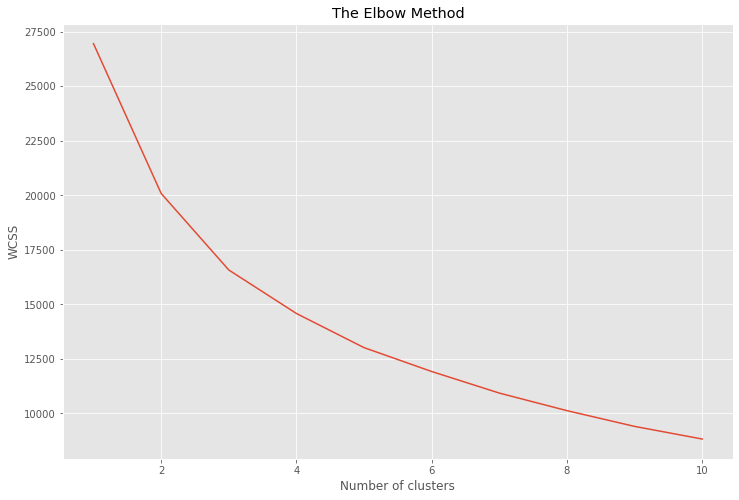

In [52]:
elbow_method()

Having performed the elbow method, one can assert that one of the k-number of clusters to use it's 5 since there we can see the elbow

##### K-Means clustering

In [53]:
def k_means(X=X_2, n_clusters=5):
    kmeans = KMeans(n_clusters = n_clusters, init = "k-means++", random_state = 42)
    y_kmeans = kmeans.fit_predict(X)
    X = np.array(X)
    plt.figure(figsize=(12, 8))
    for i in range(n_clusters):
        cl = "Cluster" + str(i + 1)
#     plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = "cyan", label = "Cluster1")
#     plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = "lightsteelblue", label = "Cluster2")
#     plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 60, c = "tomato", label = "Cluster3")
#     plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 60, c = "violet", label = "Cluster4")
#     plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 60, c = "yellow", label = "Cluster5") 
        plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s = 60, c = colors[i], label = cl)  
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = "black", label = "Centroids")
    plt.legend() 
    plt.show()

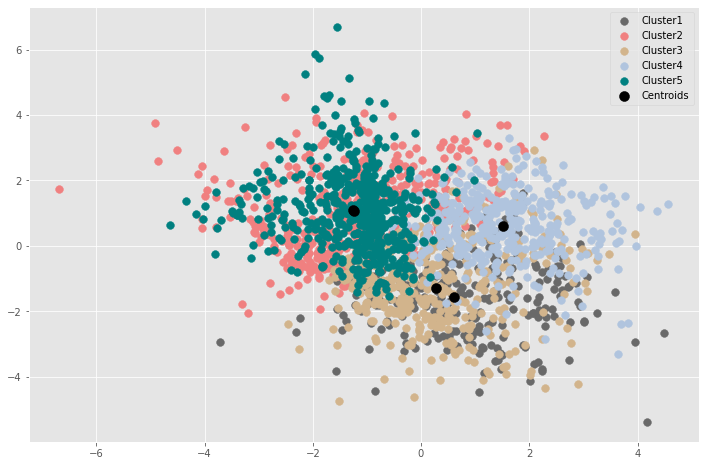

In [54]:
k_means()

Let's have a second try with a smaller number of clusters. 

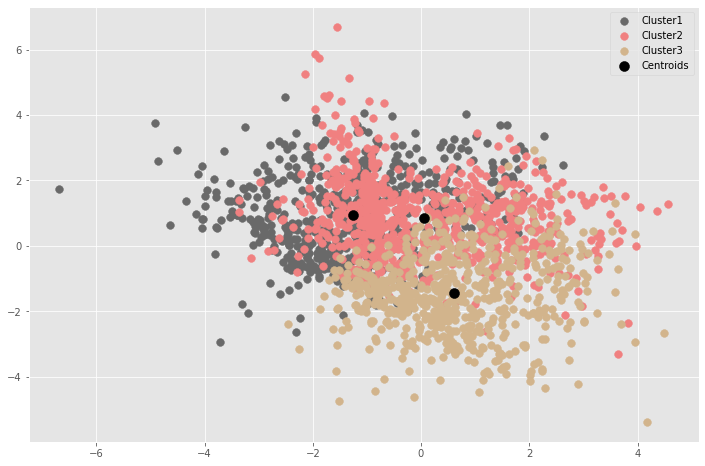

In [55]:
k_means(n_clusters=3)

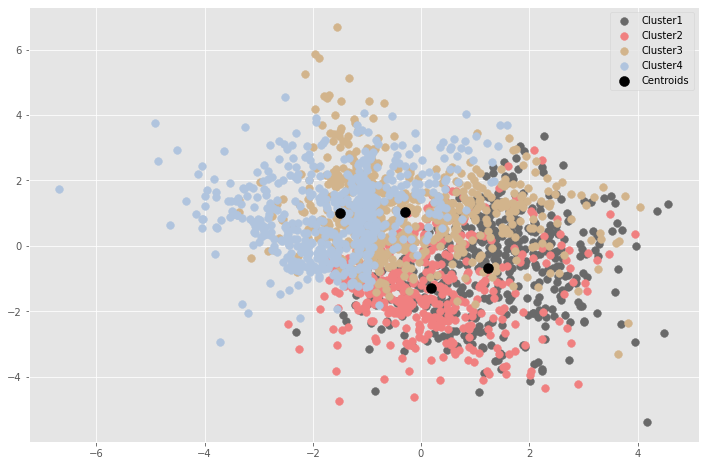

In [56]:
k_means(n_clusters=4)

##### Gaussian Mixture models

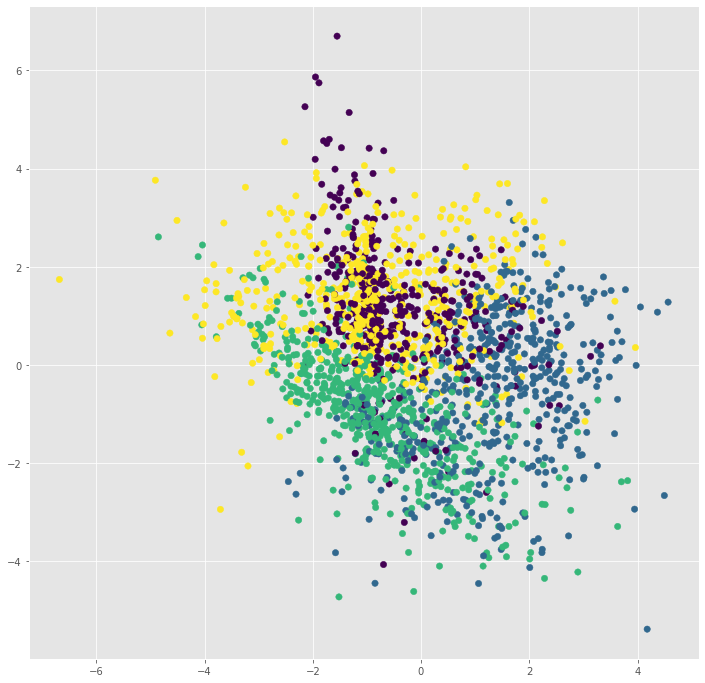

In [57]:
X_3 = np.array(X)
gmm = GaussianMixture(n_components=4).fit(X_3)
plt.figure(figsize=(12, 12))
labels = gmm.predict(X_3)
plt.scatter(X_3[:, 0], X_3[:, 1], c=labels, s=40, cmap='viridis');

In [58]:
probs = gmm.predict_proba(X_3)
print(probs[:5].round(3))

[[0.    0.066 0.    0.934]
 [0.    0.004 0.002 0.994]
 [0.4   0.344 0.141 0.116]
 [0.961 0.005 0.    0.034]
 [0.    0.074 0.547 0.378]]


### 3.Model building

We will develop our model using gridsearch over k-fold crossvalidation to tune the hyperparameters and find the most optimal combination. This might take a lot of time. Since we have a small dataset, we should reserve 30% to validation. 

In [59]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=11)

In [60]:
rfc=RandomForestClassifier(random_state=22)

In [61]:
param_grid = { 
    "n_estimators": [200, 500, 1000, 2000],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth" : [4, 5, 6, 7, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
    "criterion" :["gini", "entropy"]
}

In [62]:
%%time
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
CV_rfc.fit(x_train, y_train)

CPU times: total: 11h 31min 25s
Wall time: 11h 41min 5s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=22),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 10, 20, 30, 40, 50, 60,
                                       70, 80, 90, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 500, 1000, 2000]})

In [63]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

We extract the best hyperparameters achieved by gridsearch and put them into our model

In [73]:
rfc_2=RandomForestClassifier(random_state=42, max_features="auto", min_samples_leaf = 1,
                             min_samples_split = 2, n_estimators= 2000, max_depth=20,
                             criterion="entropy")

In [74]:
print("Parameters currently in use:\n")
pprint(rfc_2.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Now we fit the best parameters knowing that this second model is the one we will use to make predictions.

In [75]:
rfc_2.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='auto',
                       n_estimators=2000, random_state=42)

In [83]:
pred_train = rfc_2.predict(x_train)
pred = rfc_2.predict(x_val)

### 4.Model evaluation

In [84]:
print("Accuracy for Random Forest on the train data: ", accuracy_score(y_train, pred_train))
print("Accuracy for Random Forest on the test data: ", accuracy_score(y_val, pred))

Accuracy for Random Forest on the train data:  1.0
Accuracy for Random Forest on the test data:  0.7761904761904762


We overtrained to the point where our predictions are equivalent to the true label. The difference in 0.22 with the validation dataset shows that we did not overfit. 

In [78]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       127
           1       0.68      0.79      0.73       115
           2       0.79      0.67      0.73       132
           3       0.73      0.79      0.76       129
           4       0.85      0.83      0.84       127

    accuracy                           0.78       630
   macro avg       0.78      0.78      0.78       630
weighted avg       0.78      0.78      0.78       630



Text(0.5, 1.0, 'Confusion Matrix')

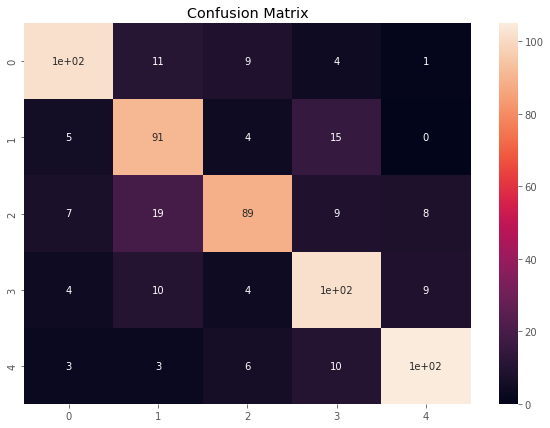

In [79]:
df_cm = pd.DataFrame(confusion_matrix(y_val, pred), index = [i for i in "01234"],
                  columns = [i for i in "01234"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix")

In [80]:
f_pred = rfc_2.predict(test)

Our metric of interest is bascially the F1-Score. Yet, since we saw the data is well balanced, one could rely on accuracy as well. There are some classes mistakenly predicted. However, we don't want to fall into overfitting either. A 70%-85% accuracy is well enough.

<!-- ##### Bootstrap -->

<!-- def bootstrap(x):
    boot_list = []
    for _ in range(10000):
        boot_sample = np.random.choice(x, replace = True, size = 50) # take a random sample each iteration
        boot_ratio = ratio(boot_sample) # calculate the mean for each iteration
        boot_list.append(boot_ratio[0]) # append the mean to boot_means or valid ratio
    boot_array = np.array(boot_list) # transform it into a numpy array for calculation
    br_mean = round(np.mean(boot_array), 3)
    br_std = round(np.std(boot_array), 3)
    br_ci = np.percentile(boot_array, [2.5, 97.5]) # 95% C.I.
    
    plt.hist(boot_array, alpha = 1)
    plt.axvline(np.percentile(boot_array,2.5),color = 'red',linewidth=2)
    plt.axvline(np.percentile(boot_array,97.5),color = 'red',linewidth=2)
     
    return br_mean, br_std, br_ci, boot_array -->

<!-- bootstrap -->

<!-- fpr, tpr, thresholds = roc_curve(y_val,pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right") -->

<!-- # Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = model_multiclass.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout() -->

### 5.Submission and conclusion

In [81]:
final_results = pd.DataFrame(f_pred)
final_results = final_results.set_axis(["final_status"], axis=1)

In [82]:
final_results.to_csv("results.csv", index = False)